In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import random
import numpy as np
import torch

# SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

## Preparing the Data

In [2]:
from torchtext.datasets import TranslationDataset

class GEC_DATASET(TranslationDataset):
    @classmethod
    def splits(cls, 
               exts, 
               fields, 
               root, 
               train="train", 
               validation="dev", 
               test="test", 
               **kwargs):
        
        return super(GEC_DATASET, cls).splits(exts=exts, 
                                      fields=fields,
                                      path=root, 
                                      root=root,
                                      train=train, 
                                      validation=validation, 
                                      test=test,
                                      **kwargs) 

In [3]:
from torchtext.data import Field
from torchtext.data import BucketIterator

def prepare_data(root):
    src_field = Field(init_token="<sos>", eos_token="<eos>", 
                      tokenize=lambda sentence: sentence.split(' '), 
                      batch_first=True)
    trg_field = Field(init_token="<sos>", eos_token="<eos>", 
                      tokenize=lambda sentence: sentence.split(' '), 
                      batch_first=True)
        
    train_set, valid_set, test_set = GEC_DATASET.splits(exts=('.src', '.trg'), 
                                                        fields=(src_field, trg_field),
                                                        root=root,
                                                        filter_pred=lambda sentence: 
                                                        len(vars(sentence)['src']) < MAX_LEN 
                                                        and len(vars(sentence)['trg']) < MAX_LEN)

    src_field.build_vocab(train_set, min_freq=MIN_FREQ)
    trg_field.build_vocab(train_set, min_freq=MIN_FREQ)

    train_iter, valid_iter, test_iter = BucketIterator.splits(
        datasets=(train_set, valid_set, test_set), 
        batch_size=BATCH_SIZE,
        device=DEVICE)
    
    return src_field, trg_field, train_iter, valid_iter, test_iter, train_set, valid_set, test_set

## Building the Model

### Encoder

In [4]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, 
                input_dim, 
                hid_dim, 
                n_layers, 
                n_heads, 
                pf_dim, 
                dropout):
        
        super().__init__()
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        
        self.pos_embedding = nn.Embedding(MAX_LEN + 1, hid_dim)  # why + 1?
        self.scale = torch.sqrt(torch.tensor([hid_dim], dtype=torch.float, device=DEVICE))

        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                 n_heads, 
                                                 pf_dim, 
                                                 dropout)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        # (in)  src: [batch_size, src_len]
        # (in)  src_mask: [batch_size, 1, 1, src_len]
        # (out) src: [batch_size, src_len, hid_dim]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # (out) pos: [batch_size, src_len]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(DEVICE)
        
        # (in)  src
        # (in)  pos
        # (out) src: [batch_size, src_len, hid_dim]
        src = self.dropout(
            self.tok_embedding(src) * self.scale + self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src

### Encoder Layer

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                hid_dim, 
                n_heads, 
                pf_dim, 
                dropout):
        
        super().__init__()
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hid_dim)
        
    def forward(self, src, src_mask):
        # (in)  src: [batch_size, src_len, hid_dim]
        # (in)  src_mask: [batch_size, 1, 1, src_len]
        # (out) src: [batch_size, src_len, hid_dim]
        
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        src = self.layer_norm(src + self.dropout(_src))
        
        _src = self.positionwise_feedforward(src)
        
        src = self.layer_norm(src + self.dropout(_src))
        
        return src

### Multi Head Attention Layer

In [6]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout):
        
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.tensor([self.head_dim], dtype=torch.float, device=DEVICE))
        
    def forward(self, query, key, value, mask=None):
        # (in)  qeury: [batch_size, query_len, hid_dim]
        # (in)  key: [batch_size, query_len, hid_dim]
        # (in)  value: [batch_size, query_len, hid_dim]
        
        batch_size = query.shape[0]
        
        # (in)  query
        # (in)  key
        # (in)  value
        # (out) Q: [batch_size, seq_len, hid_dim]
        # (out) K: [batch_size, seq_len, hid_dim]
        # (out) V: [batch_size, seq_len, hid_dim]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # (out) Q: [batch_size, n_heads, query_len, head_dim]
        # (out) K: [batch_size, n_heads, key_len, head_dim]
        # (out) V: [batch_size, n_heads, value_len, head_dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # (in)  Q
        # (in)  K
        # (out) energy: [batch_size, n_heads, query_len, key_len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
        
        # (in)  energy
        # (out) attention: [batch_size, n_heads, query_len, key_len]
        attention = torch.softmax(energy, dim=-1)  # why dim=-1?
        
        # (in)  attention
        # (out) x: [batch_size, n_heads, query_len, head_dim]
        x = torch.matmul(
            self.dropout(attention), V)
        
        # (in)  x 
        # (out) x: [batch_size, query_len, n_heads, head_dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        
        # (in)  x
        # (out) x: [batch_size, query_len, hid_dim]
        x = x.view(batch_size, -1, self.hid_dim)
        
        # (in)  x
        # (out) x: [batch_size, query_len, hid_dim]
        x = self.fc_o(x)
        
        return x, attention

### Position-wise Feedforward Layer

In [7]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        x = self.dropout(
            torch.relu(
                self.fc_1(x)))
        
        x = self.fc_2(x)
        
        return x

### Decoder

In [8]:
class Decoder(nn.Module):
    def __init__(self, 
                output_dim, 
                hid_dim, 
                n_layers, 
                n_heads, 
                pf_dim, 
                dropout):
        
        super().__init__()
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        
        self.pos_embedding = nn.Embedding(MAX_LEN + 1, hid_dim)
        self.scale = torch.sqrt(torch.tensor([hid_dim], dtype=torch.float, device=DEVICE))
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                 n_heads, 
                                                 pf_dim, 
                                                 dropout)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
                
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # (in)  trg: [batch_size, trg_len]
        # (in)  enc_src: [batch_size, src_len. hid_dim]
        # (in) trg_mask: [batch_size, 1, trg_len, trg_len]
        # (in) src_mask: [batch_size, 1, 1, src_len]
        # (out) output: [batch_size, trg_len, trg_vocab_size]
        # (out) attention: [batch_size, n_heads, trg_len, src_len]
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len, device=DEVICE).unsqueeze(0).repeat(batch_size, 1)
        
        # (in)  trg
        # (in)  pos
        # (out) trg: [batch_size, trg_len, hid_dim]
        trg = self.dropout(
            self.tok_embedding(trg) * self.scale + self.pos_embedding(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        # In PyTorch, the softmax operation is contained within our loss function, 
        # so we do not explicitly need to use a softmax layer here.
        output = self.fc_out(trg)
        
        return output, attention

### Decoder Layer

In [9]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                hid_dim, 
                n_heads, 
                pf_dim, 
                dropout):
        
        super().__init__()
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hid_dim)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # (in)  trg: [batch_size, trg_len, hid_dim]
        # (in)  enc_src: [batch_size, src_len, hid_dim]
        # (in)  trg_mask: [batch_size, 1, trg_len, trg_len]
        # (in)  src_mask: [batch_size, 1, 1, src_len]
        # (out) trg: [batch_size, trg_len, hid_dim]
        # (out) attention: [batch_size, n_heads, trg_len, src_len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        _trg = self.positionwise_feedforward(trg)
        
        trg = self.layer_norm(trg + self.dropout(_trg))
        
        return trg, attention

### Seq2Seq

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                encoder, 
                decoder, 
                src_pad_idx, 
                trg_pad_idx):
        
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        
    def forward(self, src, trg):
        # (in)  src: [batch_size, src_len]
        # (in)  trg: [batch_size, trg_len]
        # (out) output: [batch_size, trg_len, trg_vocab_size]
        # (out) attention: [batch_size, dec_heads, trg_len, src_len]
        
        # (in)  src
        # (out) src_mask: [batch_size, 1, 1, src_len]
        src_mask = self.make_src_mask(src)
        # (in)  trg
        # (out) trg_mask: [batch_size, 1, trg_len, trg_len]
        trg_mask = self.make_trg_mask(trg)
        
        # Encode.
        
        # (in)  src
        # (in)  src_mask
        # (out) enc_src: [batch_size, src_len, hid_dim]
        enc_src = self.encoder(src, src_mask)
        
        # Decode.
        
        # (in)  trg
        # (in)  enc_src
        # (in)  trg_mask
        # (in)  src_mask
        # (out) output: [batch_size, trg_len, trg_vocab_size]
        # (out) attention: [batch_size, dec_heads, trg_len, src_len]
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        return output, attention
        
    def make_src_mask(self, src):
        # (in) src: [batch_size, src_len]
        # (out) src_mask: [batch_size, 1, 1, src_len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        
        return src_mask
    
    def make_trg_mask(self, trg):
        # (in) trg: [batch_size, trg_len]
        # (out) trg_mask: [batch_size, 1, trg_len, trg_len]
        
        # (in) trg
        # (out) trg_pad_mask: [batch_size, 1, 1, trg_len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        trg_len = trg.shape[1]
        # (out) trg_sub_mask: [trg_len, trg_len]
        trg_sub_mask = torch.tril(
            torch.ones((trg_len, trg_len), device=DEVICE)).bool()
        
        # (in)  trg_pad_mask
        # (in)  trg_sub_mask
        # (out) trg_mask: [batch_size, 1, trg_len, trg_len]
        trg_mask = trg_pad_mask & trg_sub_mask
        
        return trg_mask

## Training the Seq2Seq Model

In [11]:
def init_weights(m):
    if hasattr(m, "weight") and m.weight.dim() > 1:  # dim <= 1: layernorm
        nn.init.xavier_uniform_(m.weight.data)

### Training and Validating

In [12]:
def _train(model, iterator, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        src = batch.src
        trg = batch.trg
        
        # As we want our model to predict the <eos> token but not have it be an input 
        # into our model we simply slice the <eos> token off the end of the sequence. 
        output, _ = model(src, trg[:,:-1])
            
        output = output.contiguous().view(-1, output.shape[-1])
        # We then calculate our loss using the original trg tensor with the <sos> token 
        # sliced off the front, leaving the <eos> token:
        trg = trg[:,1:].contiguous().view(-1)
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [13]:
def _evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        
        for batch in iterator:
            
            src = batch.src
            trg = batch.trg
            
            output, _ = model(src, trg[:, :-1])
            
            output = output.contiguous().view(-1, output.shape[-1])
            trg = trg[:, 1:].contiguous().view(-1)
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    
    return elapsed_mins, elapsed_secs

In [15]:
import time
import math

def train(train_iter, valid_iter, model, criterion, optimizer):
    
    best_valid_loss = float("inf")

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss = _train(model, train_iter, optimizer, criterion)
        valid_loss = _evaluate(model, valid_iter, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), PT)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [16]:
def test(test_iter, model, criterion):
    test_loss = _evaluate(model, test_iter, criterion)

    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

## Inference

In [17]:
def correct_sentence(sentence, src_field, trg_field, model):
    
    model.eval()
    
    # Prepares for data.
    
    if isinstance(sentence, str):
        tokens = [token for token in sentence.split(' ')]
    else:
        tokens = sentence
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    # Encode.
    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.tensor(src_indexes, dtype=torch.long, device=DEVICE).unsqueeze(0)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
        
    # Decode.
    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    for i in range(MAX_LEN):
        trg_tensor = torch.tensor(trg_indexes, dtype=torch.long, device=DEVICE).unsqueeze(0)
        
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()
        
        trg_indexes.append(pred_token)
        
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
            
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attention

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15, 25))
    
    for i in range(n_heads):
        
        # Gets the attention of the i^th head.
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        
        ax = fig.add_subplot(n_rows, n_cols, i + 1)        
        cax = ax.matshow(_attention, cmap="bone")
        
        ax.tick_params(labelsize=12)
        
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], 
                          rotation=45)
        ax.set_yticklabels([''] + translation)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
    plt.show()
    plt.close()

In [19]:
def inference(dataset, src_field, trg_field, model):
    
    for _ in range(10):
        example_idx = random.randint(1, len(dataset))
        
        src = vars(dataset.examples[example_idx])['src']
        trg = vars(dataset.examples[example_idx])['trg']

        print(f"src = {' '.join(src).replace('@@ ', '')}")
        print(f"trg = {' '.join(trg).replace('@@ ', '')}")
        
        correction, attention = correct_sentence(src, src_field, trg_field, model)
        
        print(f"out = {' '.join(correction[:-1]).replace('@@ ', '')}")
        
        print('---')
        
        display_attention(src, correction, attention)
    
    print()

## BLEU

In [20]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)["src"]
        trg = vars(datum)["trg"]
        
        pred_trg, _ = correct_sentence(src, src_field, trg_field, model)
        
        # Cuts off <eos>.
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

## Main

In [21]:
import torch
import torch.optim as optim

if __name__ == '__main__':
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    DATASET = "fce with bpe"
    
    # Prepares for data.
    ROOT = f"../data/{DATASET}/parallel"
    MAX_LEN = 100
    MIN_FREQ = 1
    BATCH_SIZE = 64

    src_field, trg_field, train_iter, valid_iter, test_iter, train_set, valid_set, test_set = prepare_data(root=ROOT)
    
    # Model.
    INPUT_DIM = len(src_field.vocab)
    OUTPUT_DIM = len(trg_field.vocab)
    HID_DIM = 256
    ENC_LAYERS = 3
    DEC_LAYERS = 3
    ENC_HEADS = 8
    DEC_HEADS = 8
    ENC_PF_DIM = 512
    DEC_PF_DIM = 512
    ENC_DROPOUT = 0.1
    DEC_DROPOUT = 0.1
    
    SRC_PAD_IDX = src_field.vocab.stoi[src_field.pad_token]
    TRG_PAD_IDX = trg_field.vocab.stoi[trg_field.pad_token]
    
    enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT)

    dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT)    

    model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX).to(DEVICE)
    model.apply(init_weights)
    
    # Criterion.
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
    
    # Optimizer.
    LEARNING_RATE = 0.0005
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-09)
    
    # Trains and validates.
    N_EPOCHS = 20
    CLIP = 1
    PT = f"transformer (tutorial settings) with {DATASET}.pt"
    
    train(train_iter, valid_iter, model, criterion, optimizer)
    
    # Tests.
    model.load_state_dict(torch.load(PT))
    test(test_iter, model, criterion)

Epoch: 01 | Time: 0m 36s
	Train Loss: 4.326 | Train PPL:  75.616
	 Val. Loss: 2.696 |  Val. PPL:  14.813
Epoch: 02 | Time: 0m 36s
	Train Loss: 2.472 | Train PPL:  11.851
	 Val. Loss: 1.848 |  Val. PPL:   6.350
Epoch: 03 | Time: 0m 36s
	Train Loss: 1.792 | Train PPL:   6.003
	 Val. Loss: 1.511 |  Val. PPL:   4.532
Epoch: 04 | Time: 0m 36s
	Train Loss: 1.411 | Train PPL:   4.099
	 Val. Loss: 1.318 |  Val. PPL:   3.736
Epoch: 05 | Time: 0m 36s
	Train Loss: 1.152 | Train PPL:   3.163
	 Val. Loss: 1.190 |  Val. PPL:   3.286
Epoch: 06 | Time: 0m 36s
	Train Loss: 0.963 | Train PPL:   2.620
	 Val. Loss: 1.101 |  Val. PPL:   3.008
Epoch: 07 | Time: 0m 36s
	Train Loss: 0.820 | Train PPL:   2.271
	 Val. Loss: 1.046 |  Val. PPL:   2.847
Epoch: 08 | Time: 0m 36s
	Train Loss: 0.710 | Train PPL:   2.034
	 Val. Loss: 0.981 |  Val. PPL:   2.667
Epoch: 09 | Time: 0m 36s
	Train Loss: 0.622 | Train PPL:   1.862
	 Val. Loss: 0.964 |  Val. PPL:   2.622
Epoch: 10 | Time: 0m 36s
	Train Loss: 0.544 | Train PPL

training inference
src = I was absolutely threaled to resive news about my win in a competition .
trg = I was absolutely thrilled to receive the news about my winning a competition .
out = I was absolutely thrilled to receive news about my winning a competition .
---


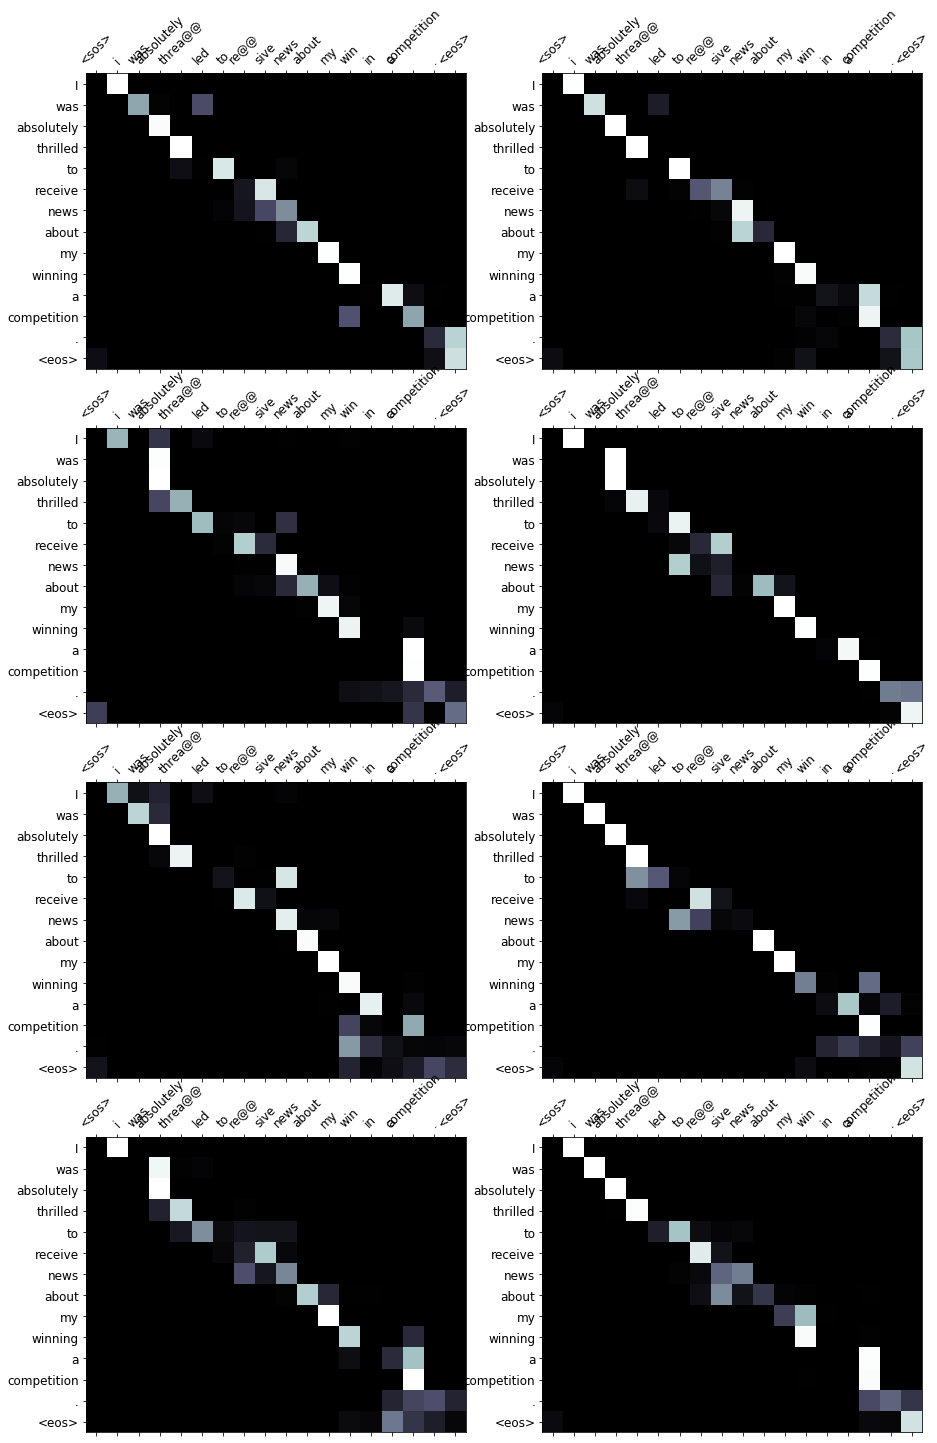

src = Yours sincerely ,
trg = Yours sincerely ,
out = Yours sincerely ,
---


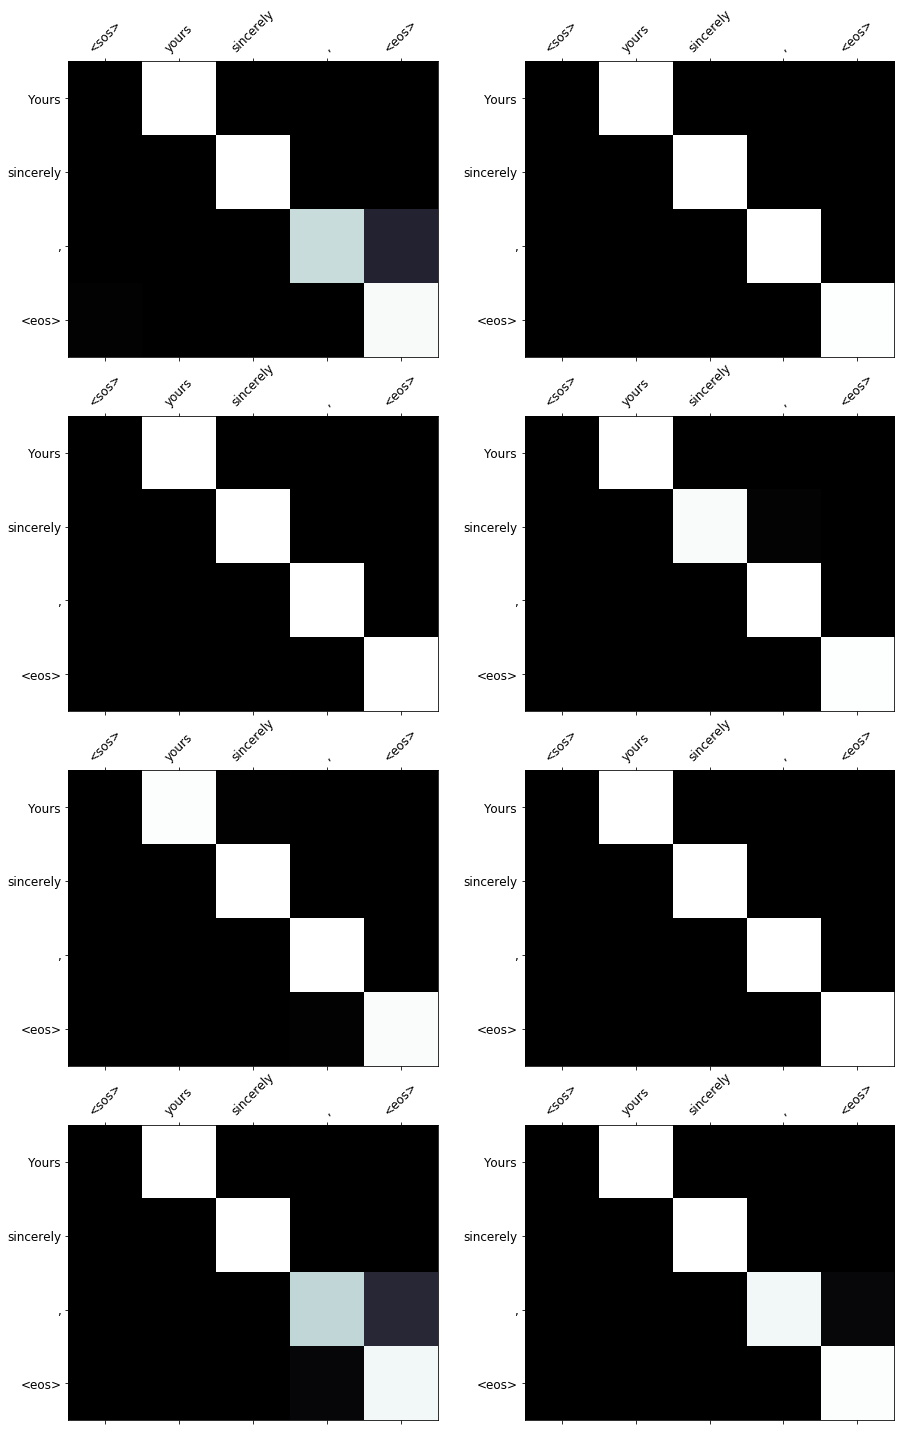

src = They told me Pat used to be a close friend of them and she used to talk about me and my problems .
trg = They told me Pat used to be a close friend of theirs and she used to talk about me and my problems .
out = They told me Pat used to be a close friend of them and she used to talk about me and my problems .
---


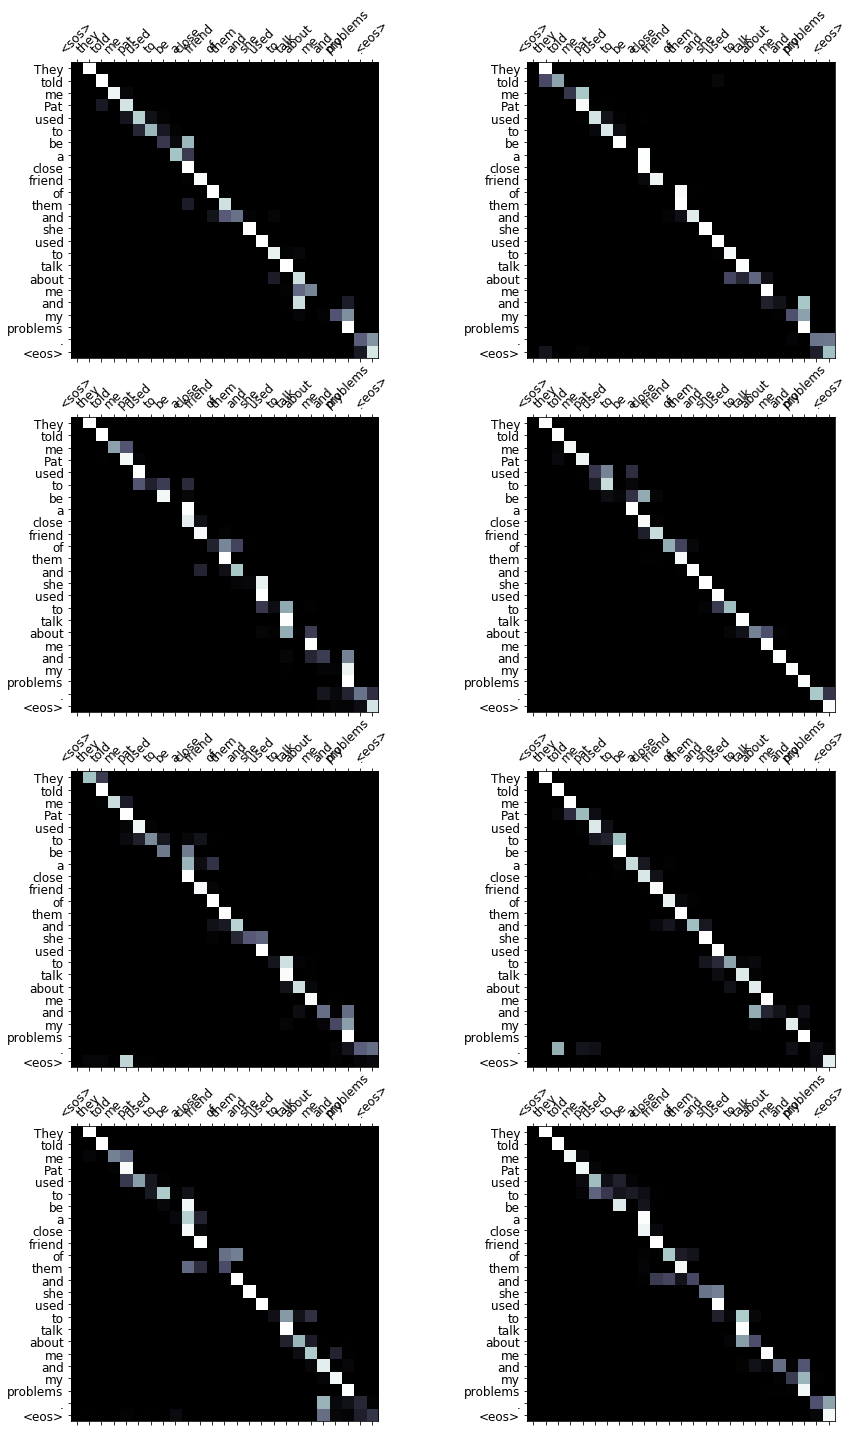

src = She came near to me and said " Ready for this evening ?
trg = She came up to me and said " Ready for this evening ?
out = She came to me and said " Ready for this evening ?
---


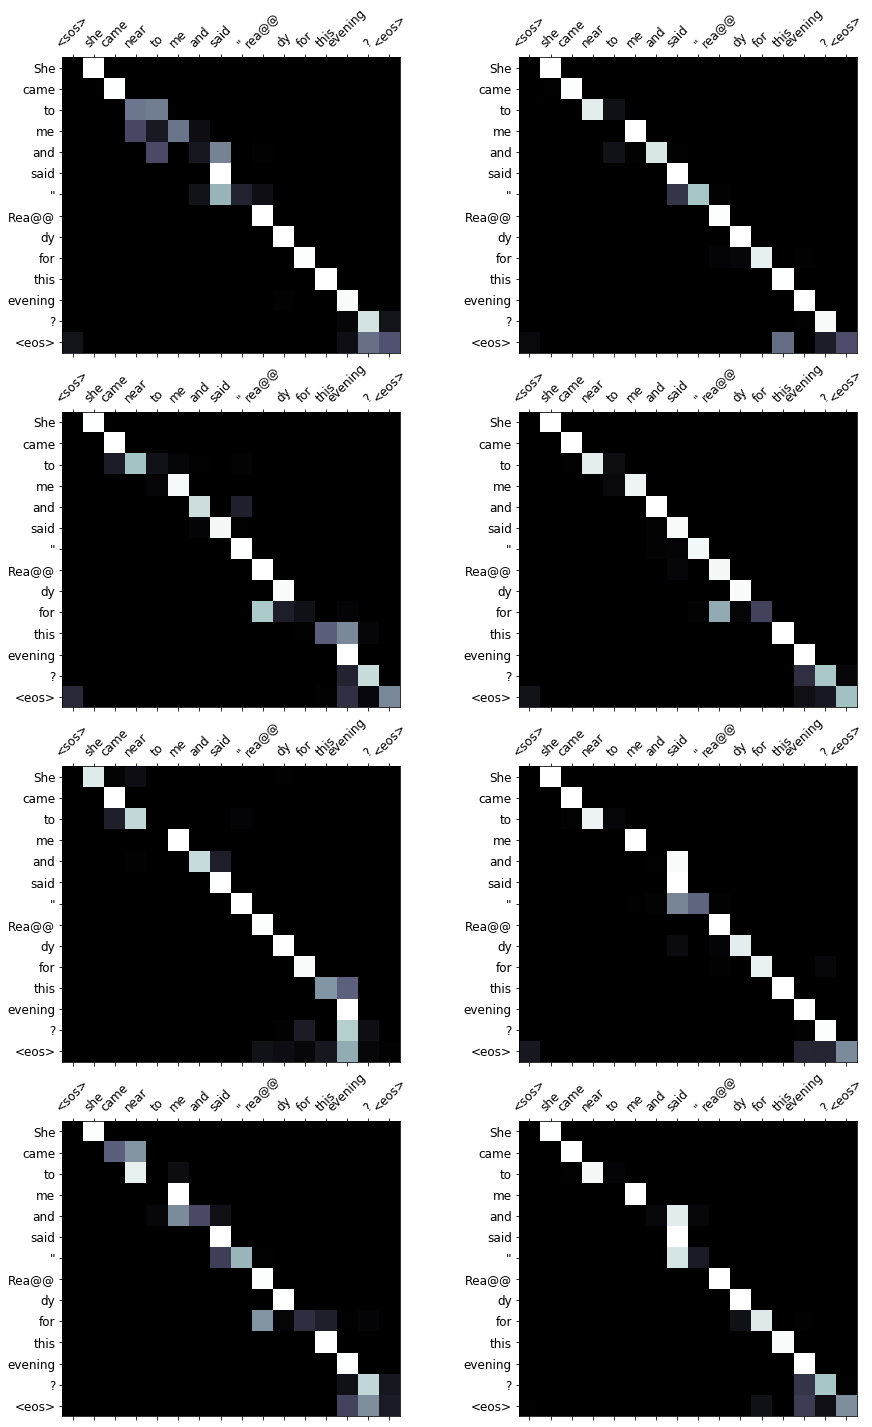

src = Every Friday , they enjoy a special game for check vocabulary .
trg = Every Friday , they enjoy a special game to check vocabulary .
out = Every Friday , they enjoy a special game to check vocabulary .
---


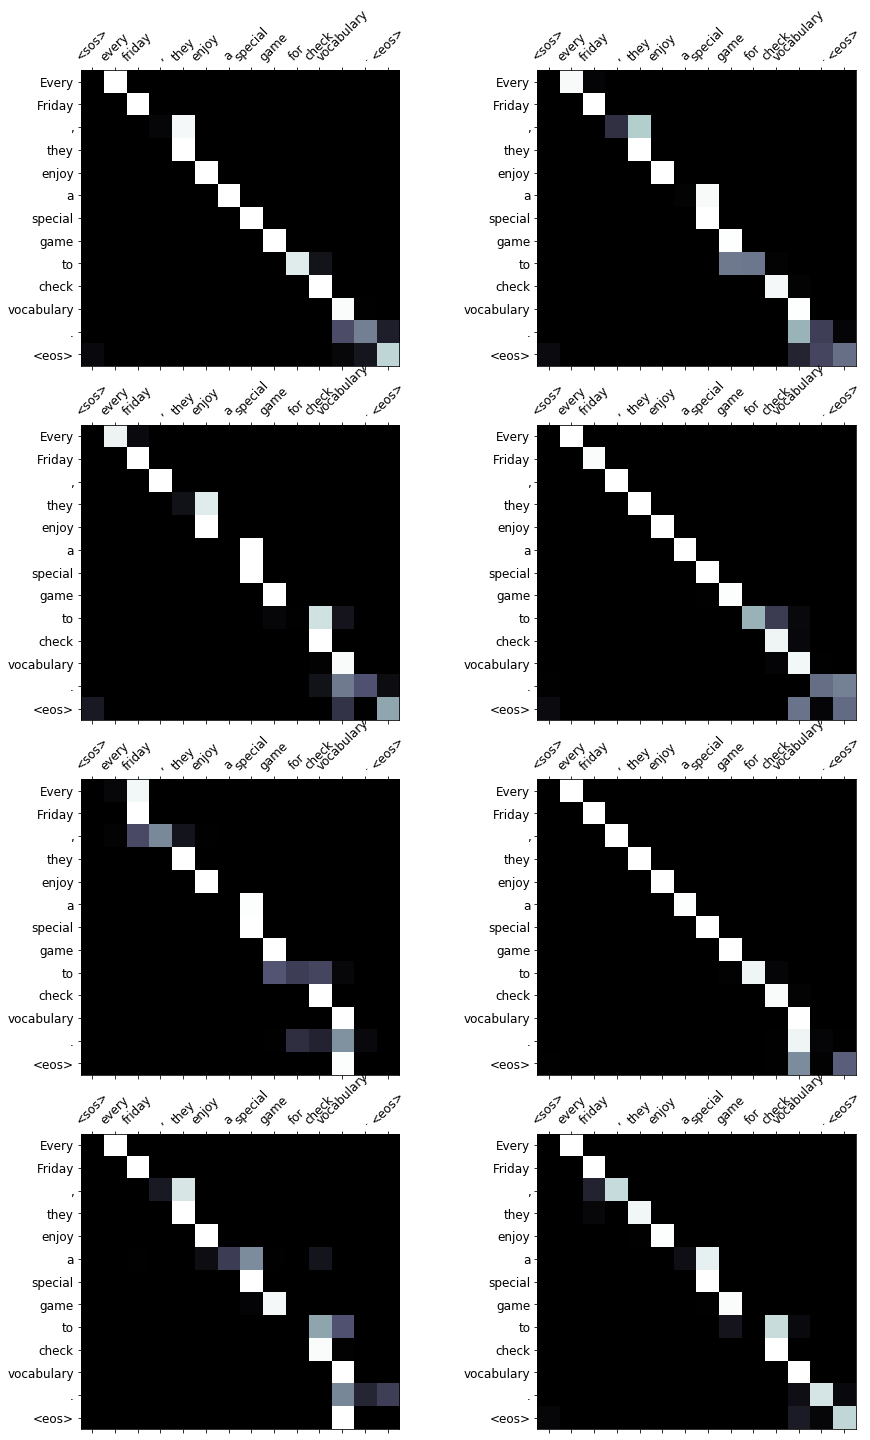

src = Although , this musical show was not as good as I expected .
trg = However , this musical was not as good as I expected .
out = Although , this musical show was not as good as I expected .
---


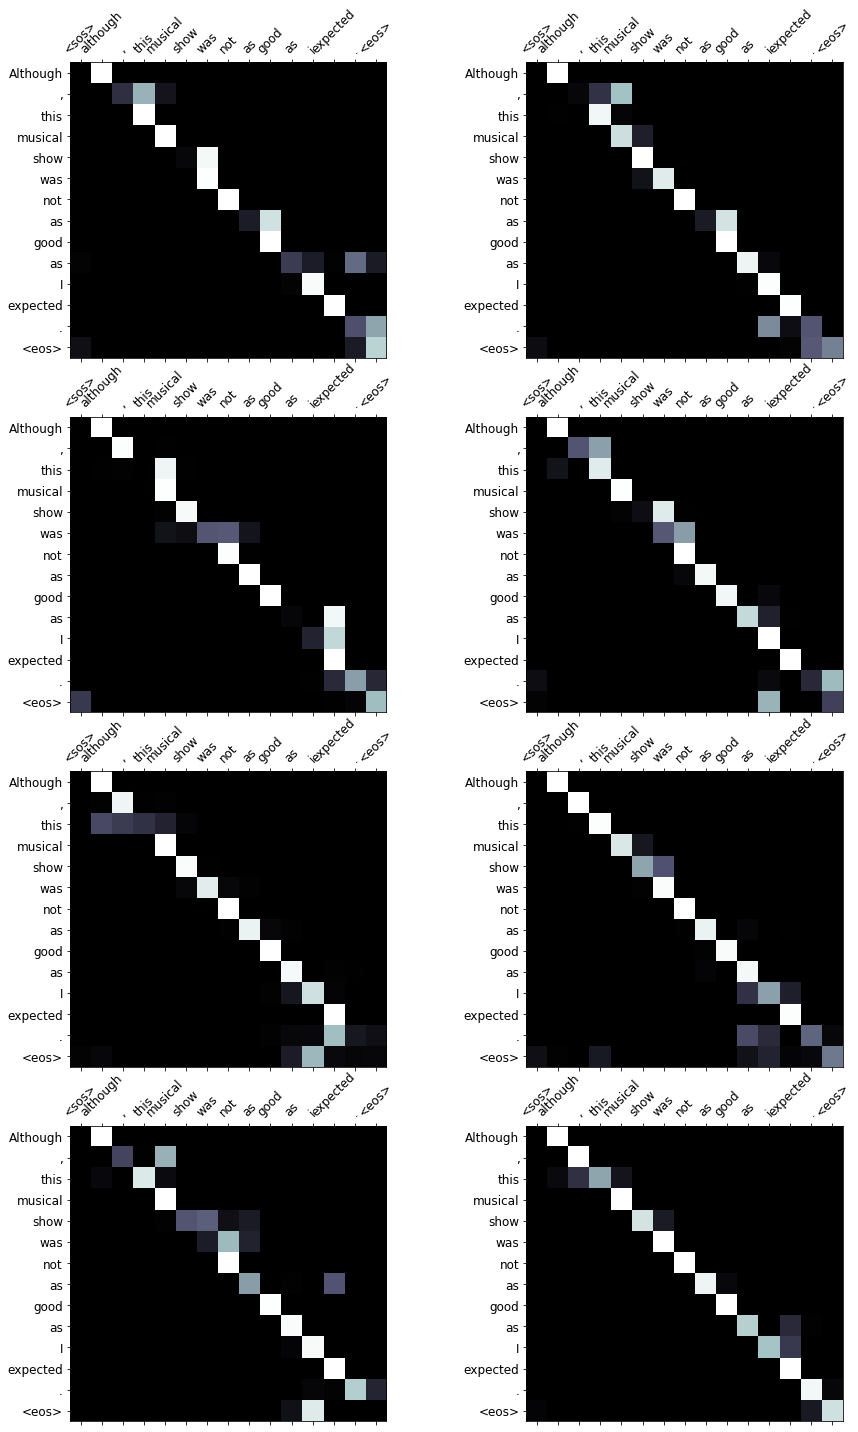

src = After long hours of hesitation , you decide to buy a product but discover that it is out of price .
trg = After long hours of hesitation , you decide to buy a product but discover that it is overpriced .
out = After long hours of hesitation , you decide to buy a product but discover that it is out of the price .
---


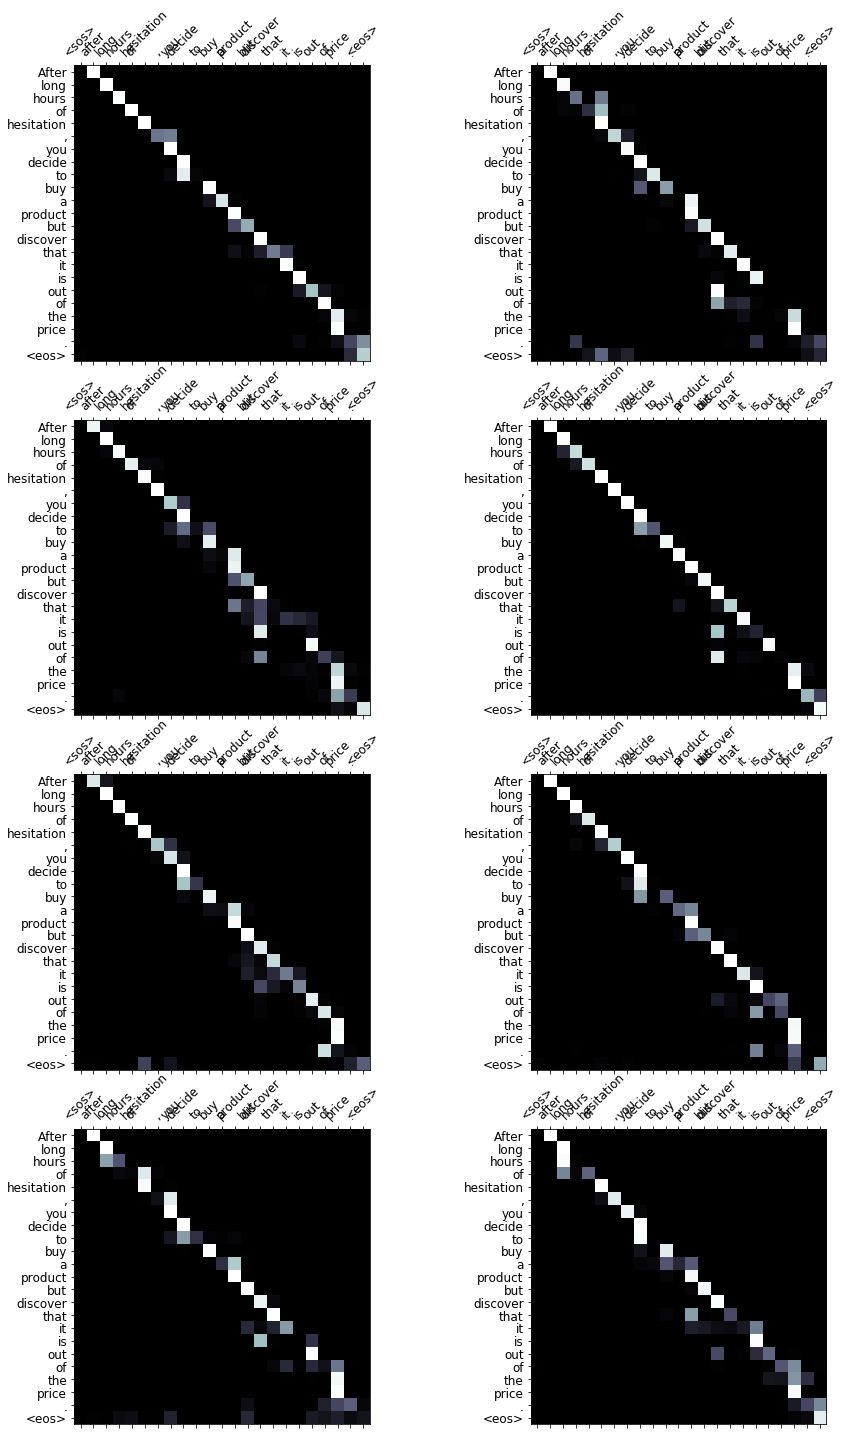

src = If it were n't a calm and quite public , we would have had troubles .
trg = If it had n't been a calm and quiet crowd , we would have had trouble .
out = If it were n't a calm and quite public , we would have had trouble .
---


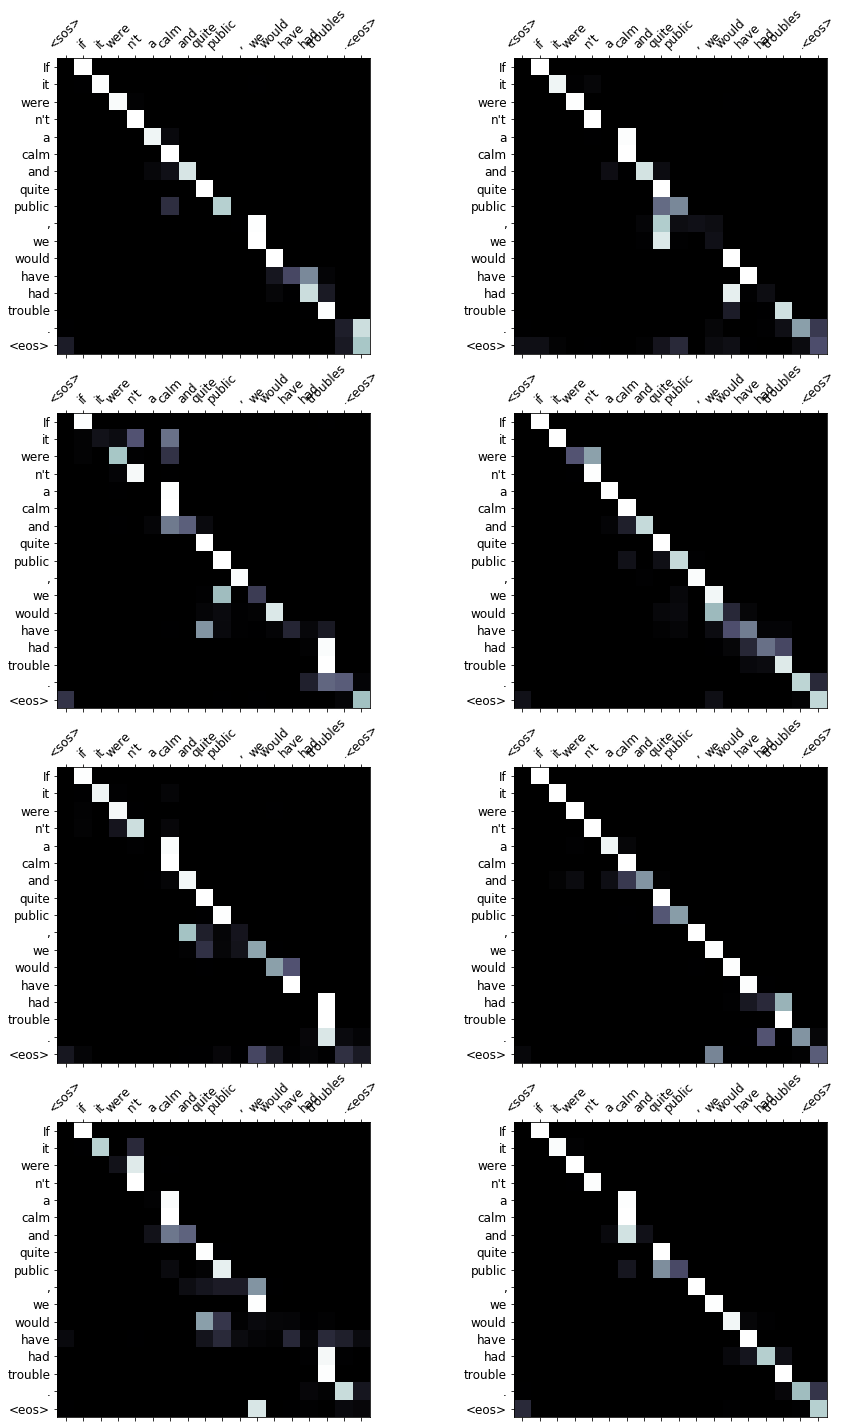

src = A further disadvantage is that children are growing up very lazy .
trg = A further disadvantage is that children are growing up very lazy .
out = A further disadvantage is that children are growing up very lazy .
---


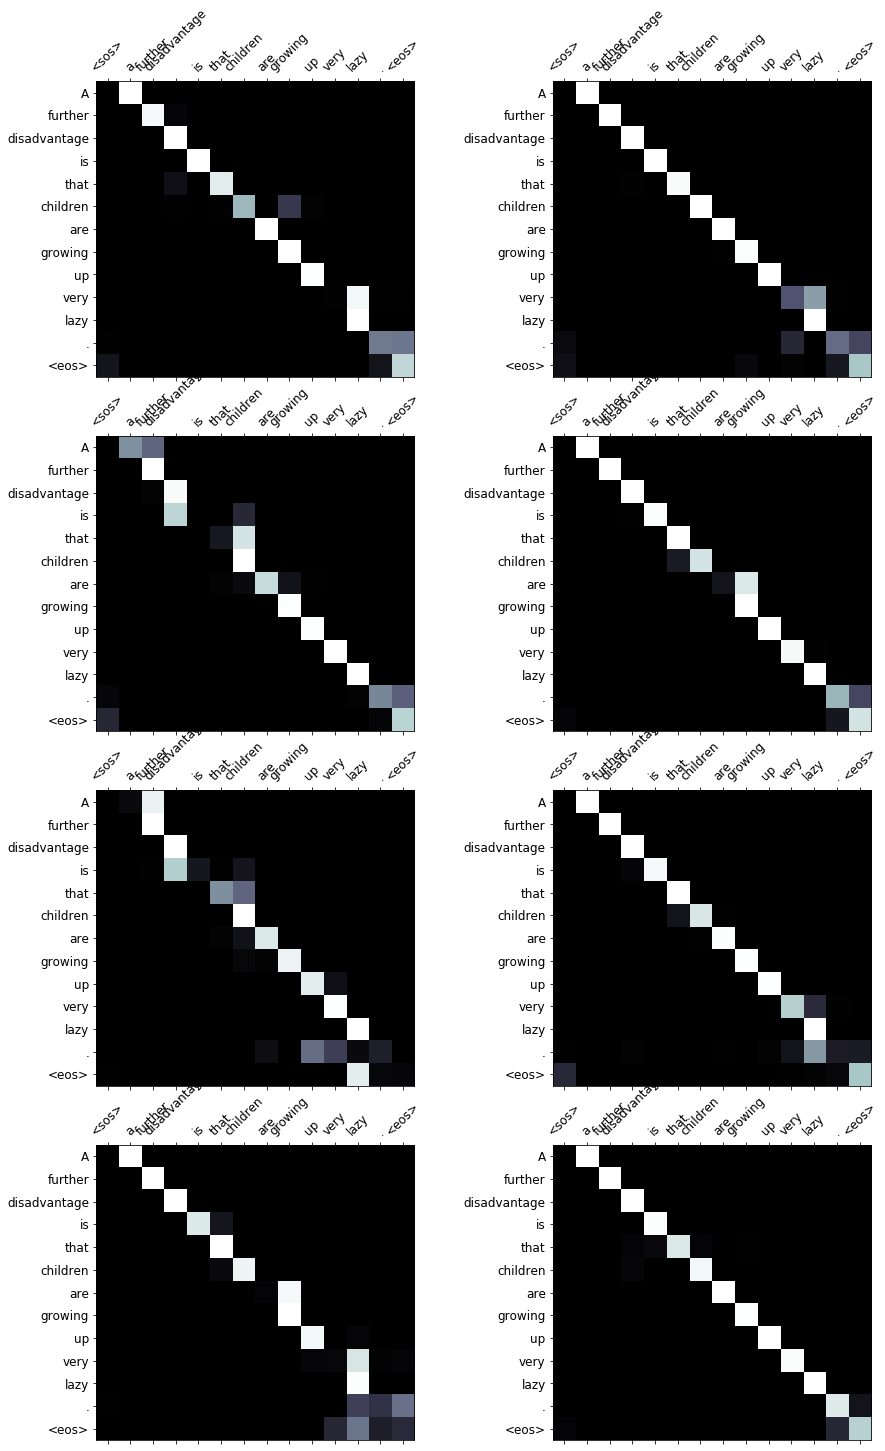

src = 1 . - I would prefer long cabins rather than tents , because it is much more comfortable .
trg = 1 . - I would prefer a log cabin rather than a tent , because it is much more comfortable .
out = 1 . - I would prefer a log cabin rather than tents , because it is much more comfortable .
---


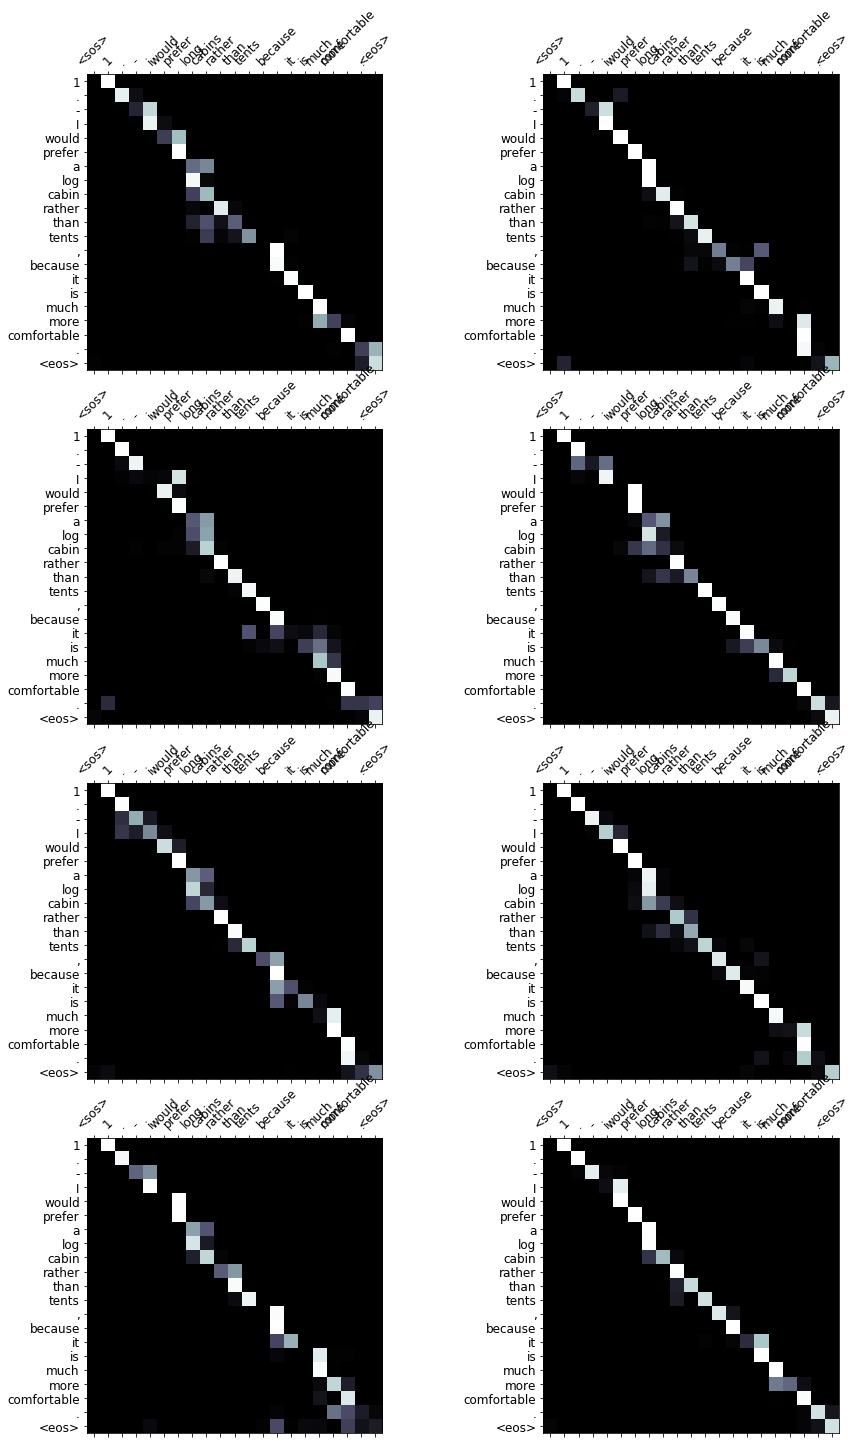

In [22]:
print("training inference")
inference(train_set, src_field, trg_field, model)

validating inference
src = I can know what is happening in differents parts of the world in a few minutes .
trg = I can find out what is happening in different parts of the world in a few minutes .
out = I can know what is happening in different parts of the world in a few minutes .
---


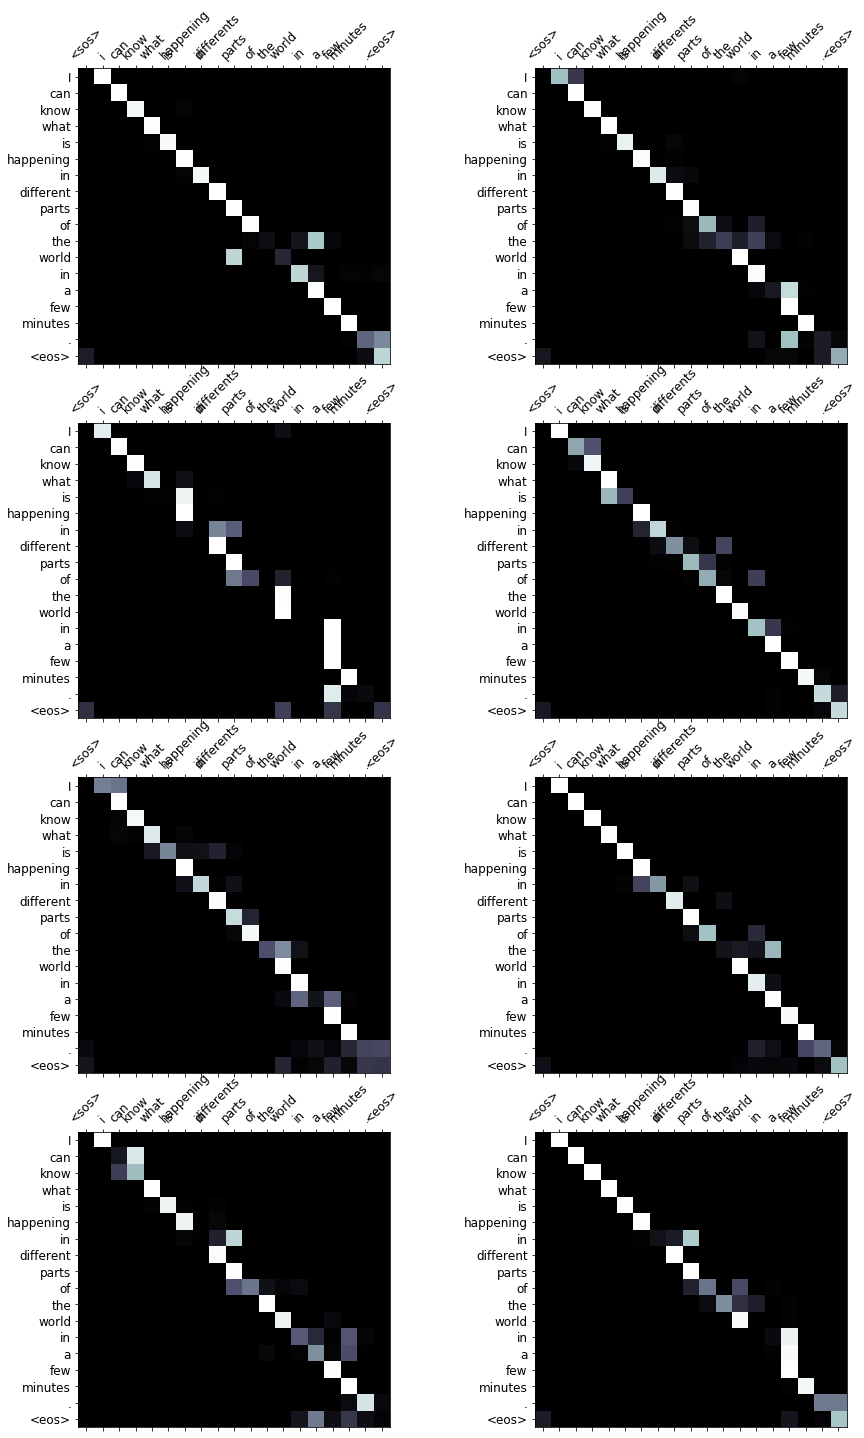

src = I am a student in Liverpool , and recently I had a week 's holiday in London .
trg = I am a student in Liverpool , and recently I had a week 's holiday in London .
out = I am a student in Liverpool , and recently I had a week 's holiday in London .
---


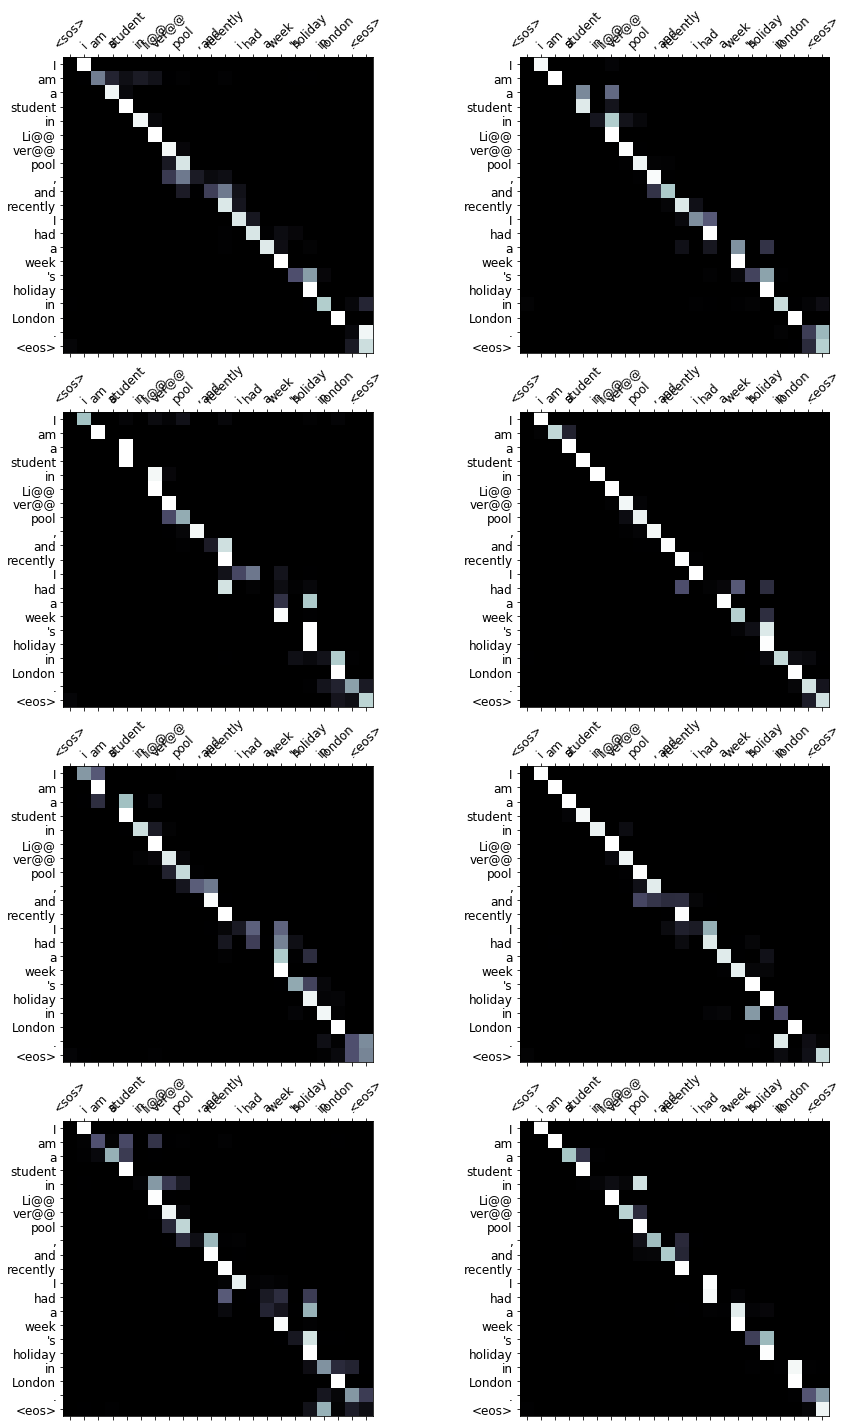

src = Just imagine the way of future people 's life .
trg = Just imagine the future people 's way of life .
out = Just imagine the way of future people 's life .
---


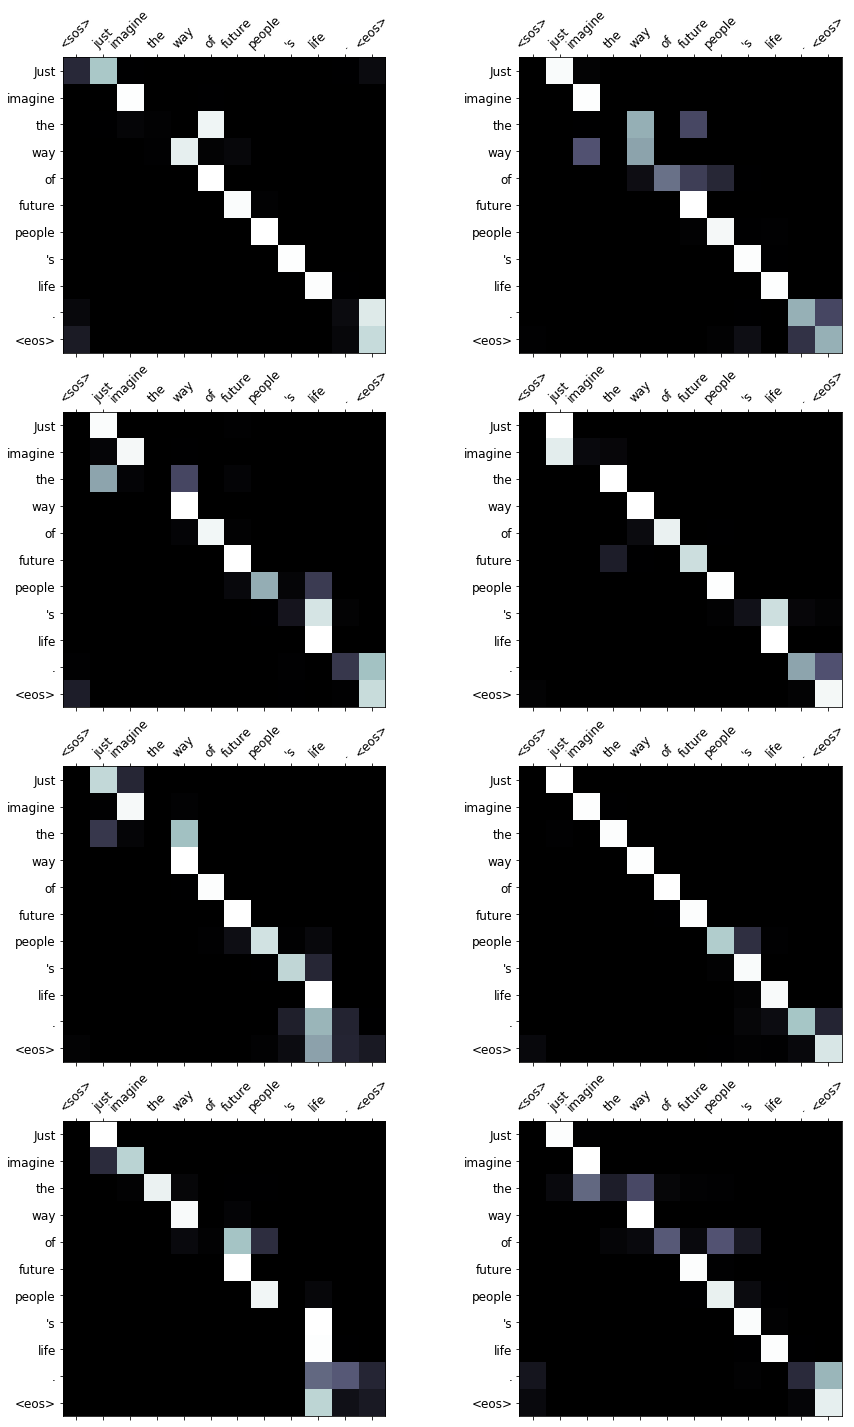

src = Unfortunately , Pat was n't very good at keeping secrets .
trg = Unfortunately , Pat was n't very good at keeping secrets .
out = Unfortunately , Pat was n't very good at keeping secrets .
---


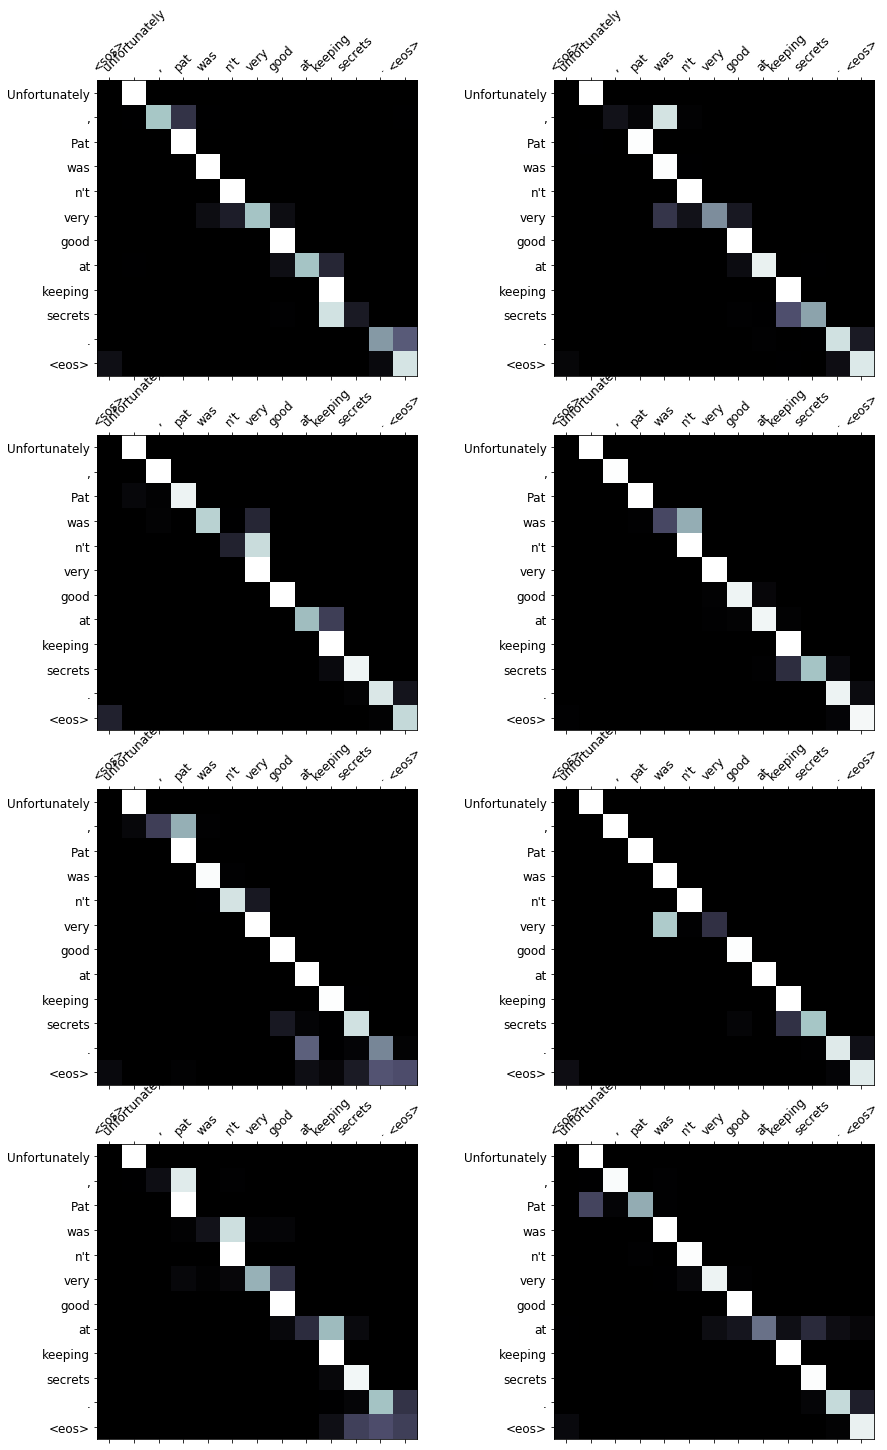

src = My job was to leave some leaflets on shops , restaurants and streets .
trg = My job was to leave some leaflets in shops , restaurants and on the streets .
out = My job was to leave some leaflets in shops , and streets .
---


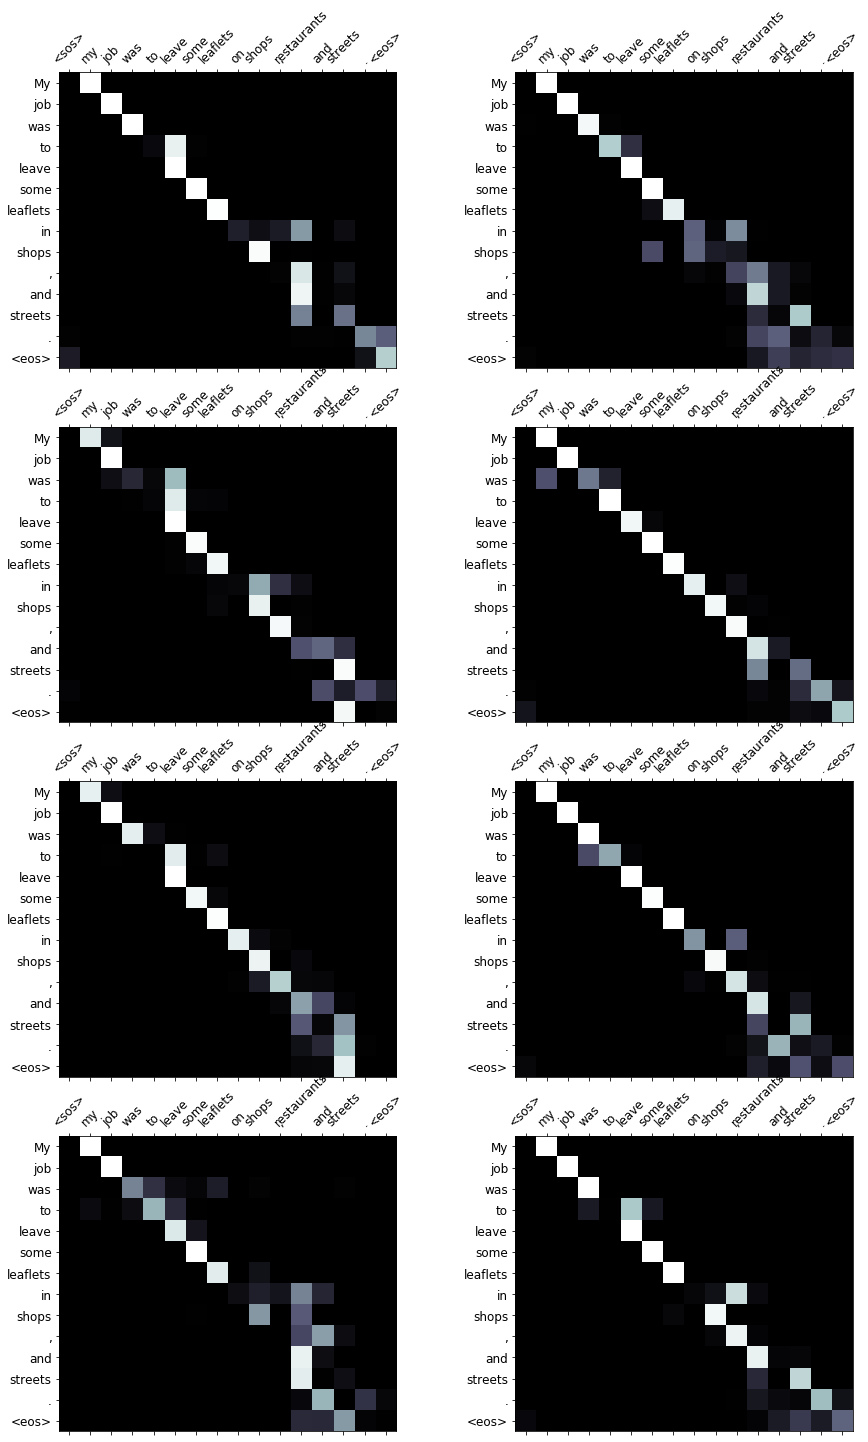

src = My life is changing too .
trg = My life is changing too .
out = My life is changing too .
---


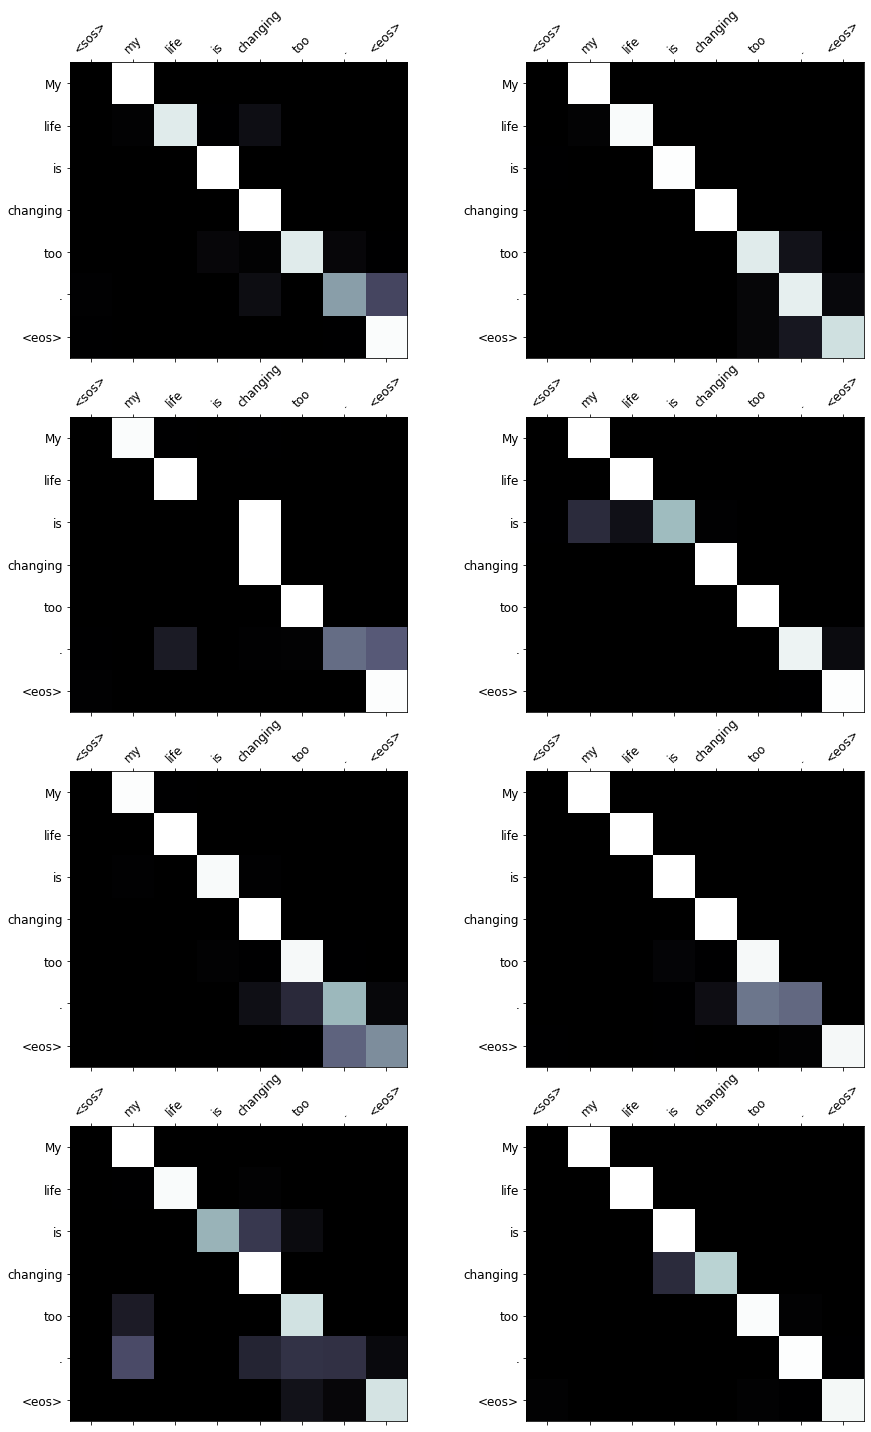

src = 50 years ago , Korean mothers should have made a fire by burning woods to warm a room up and make food .
trg = 50 years ago , Korean mothers should have made a fire by burning wood to warm a room up and make food .
out = 50 years ago , Korea should have made a fire by burning wood to be warm to warm the room and make food .
---


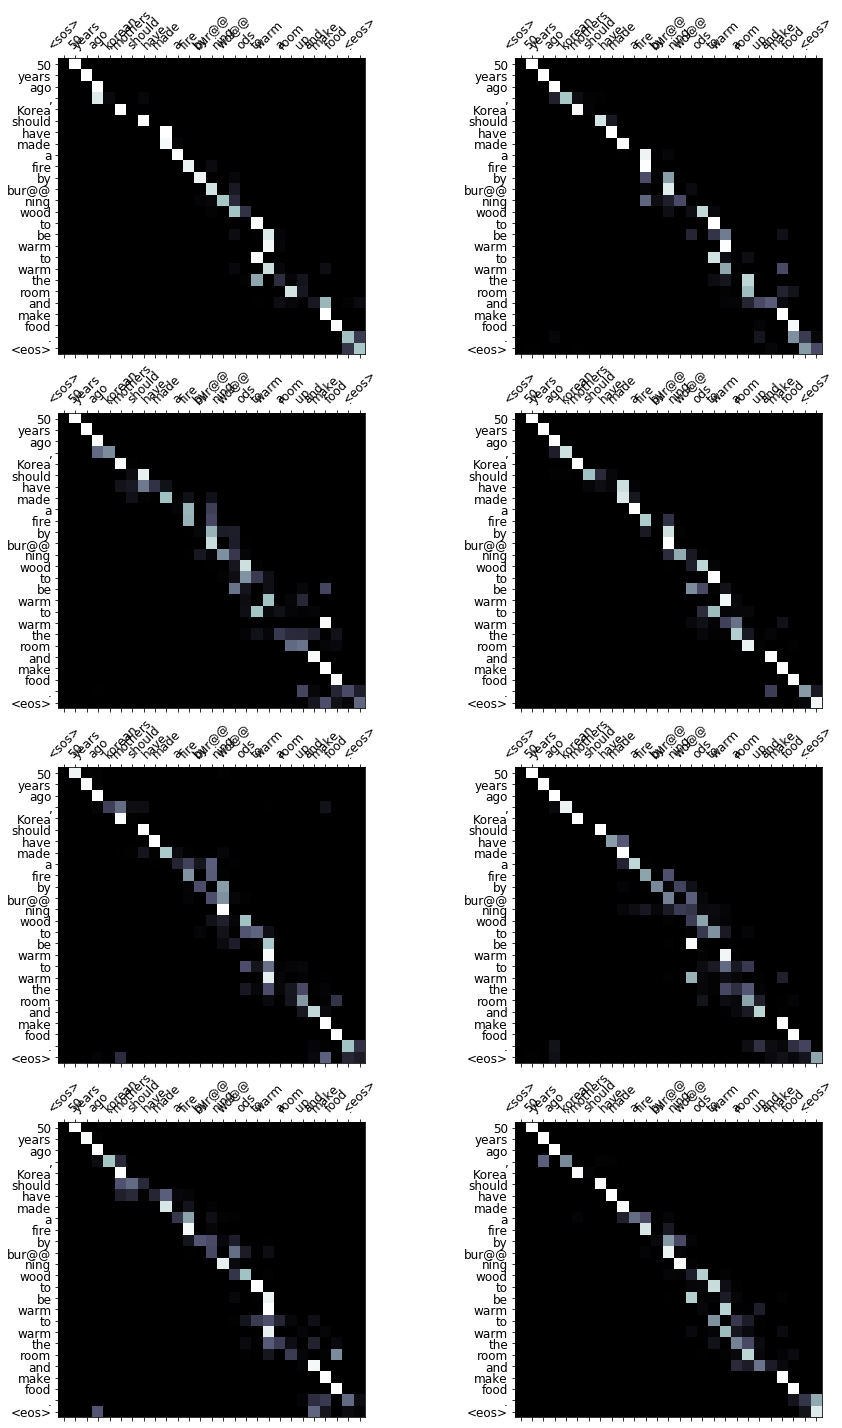

src = IN MY OPINION , PEOPLE WILL GIVE IMPORTANCE TO HOW THEIR PERSONALITY DEVELOP AND THEY WILL GIVE UP WORRYING ABOUT WHAT THEY WEAR .
trg = IN MY OPINION , PEOPLE WILL ATTACH IMPORTANCE TO HOW THEIR PERSONALITIES DEVELOP AND THEY WILL GIVE UP WORRYING ABOUT WHAT THEY WEAR .
out = IN MY OPINION , WILL GIVE OF THE SHOW TO THEIR PEOPLE 'S TUATION AND THEY WILL GIVE A P THGIVE A GRTHROUTINYING WHAT THEY ARE ON SCHOOL .
---


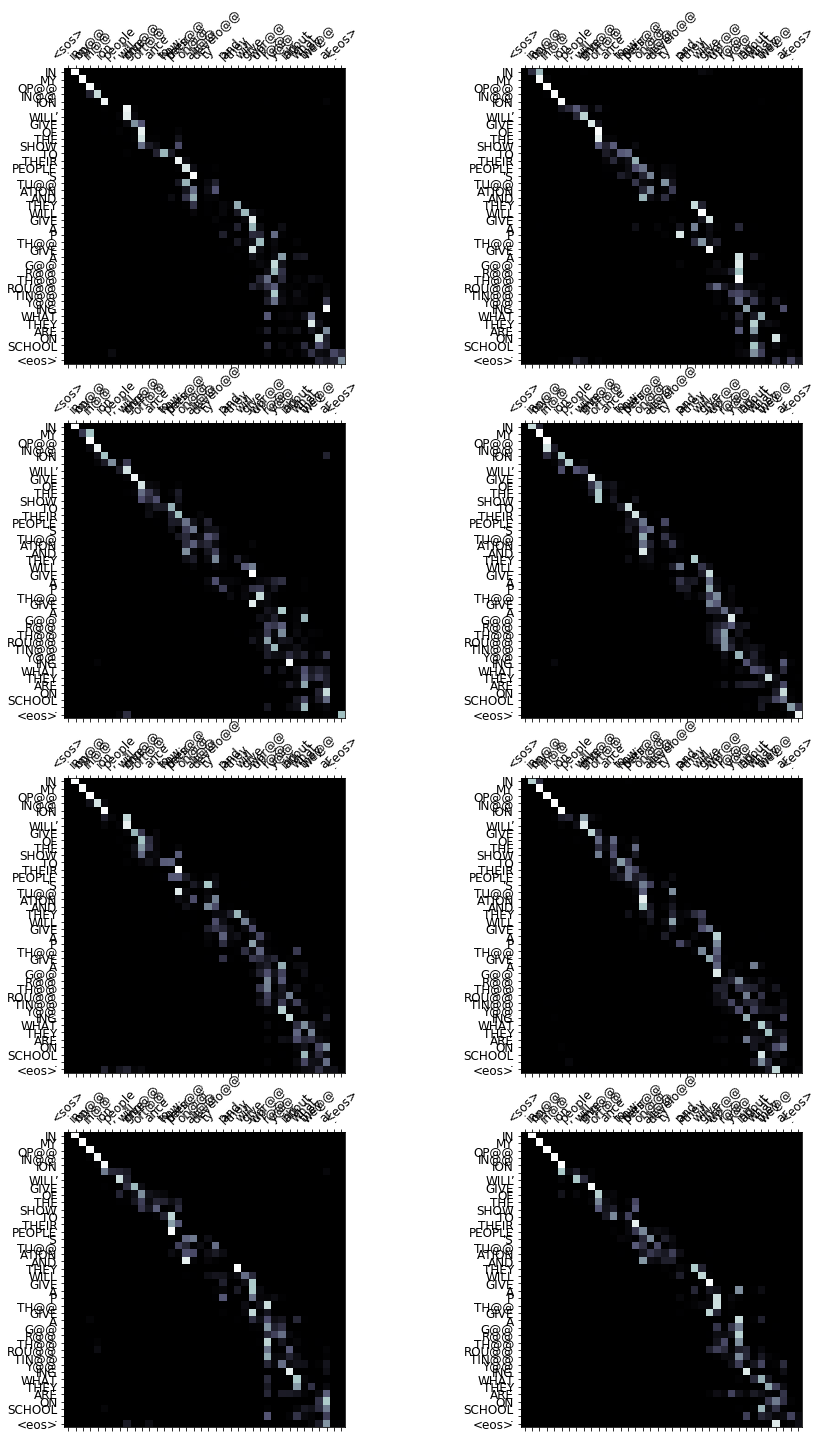

src = First of all , I am available to travel in July from 1st to 20th because my university will be closed during this month .
trg = First of all , I am available to travel in July from 1st to 20th because my university will be closed during that month .
out = First of all , I am available to travel in July from 1st to travel 1st because my university will be closed during that month .
---


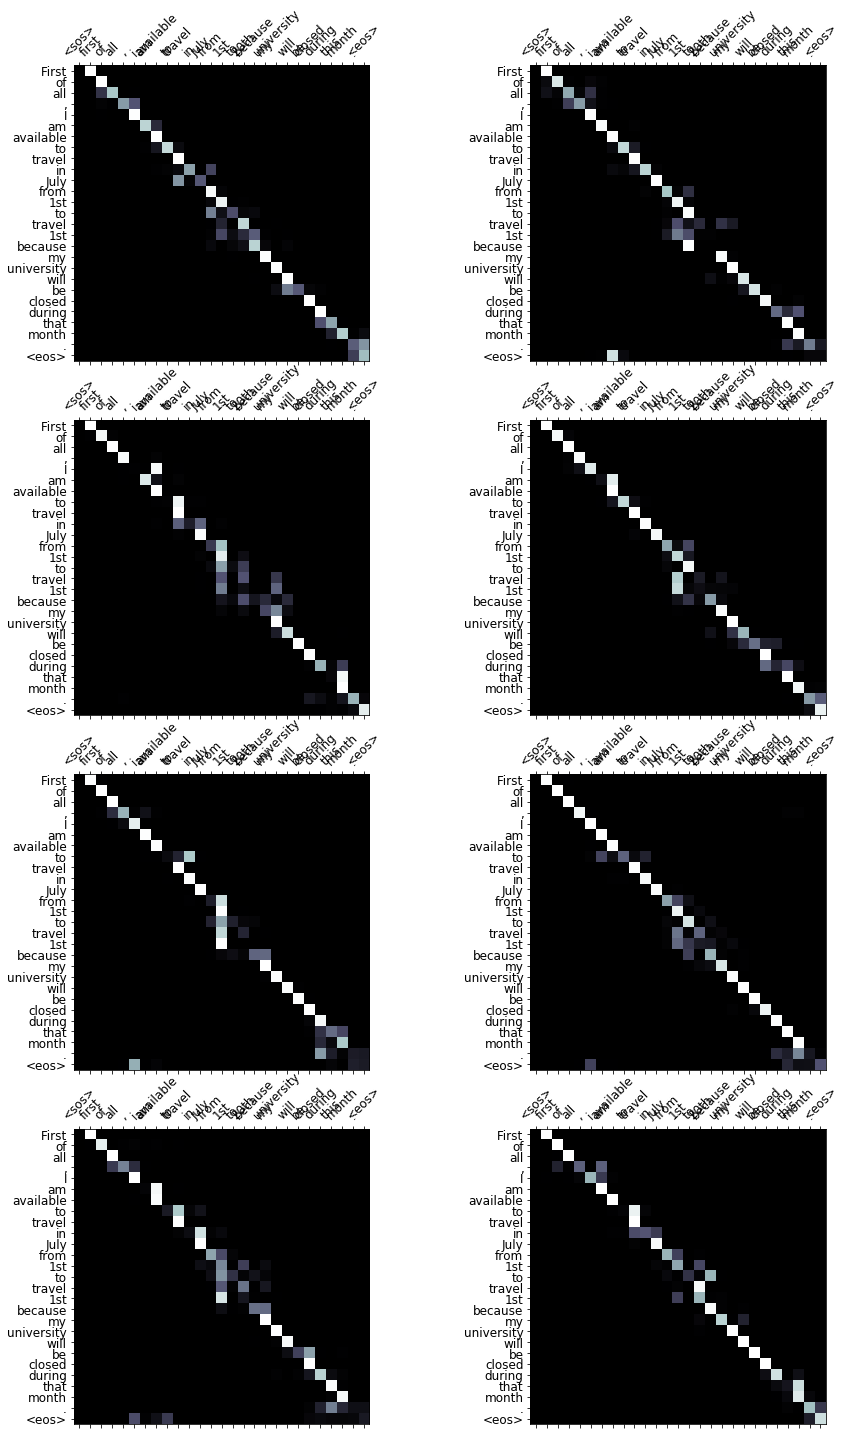

src = And now to be the first winner .
trg = And now to win first prize !
out = And now to be the first winner .
---


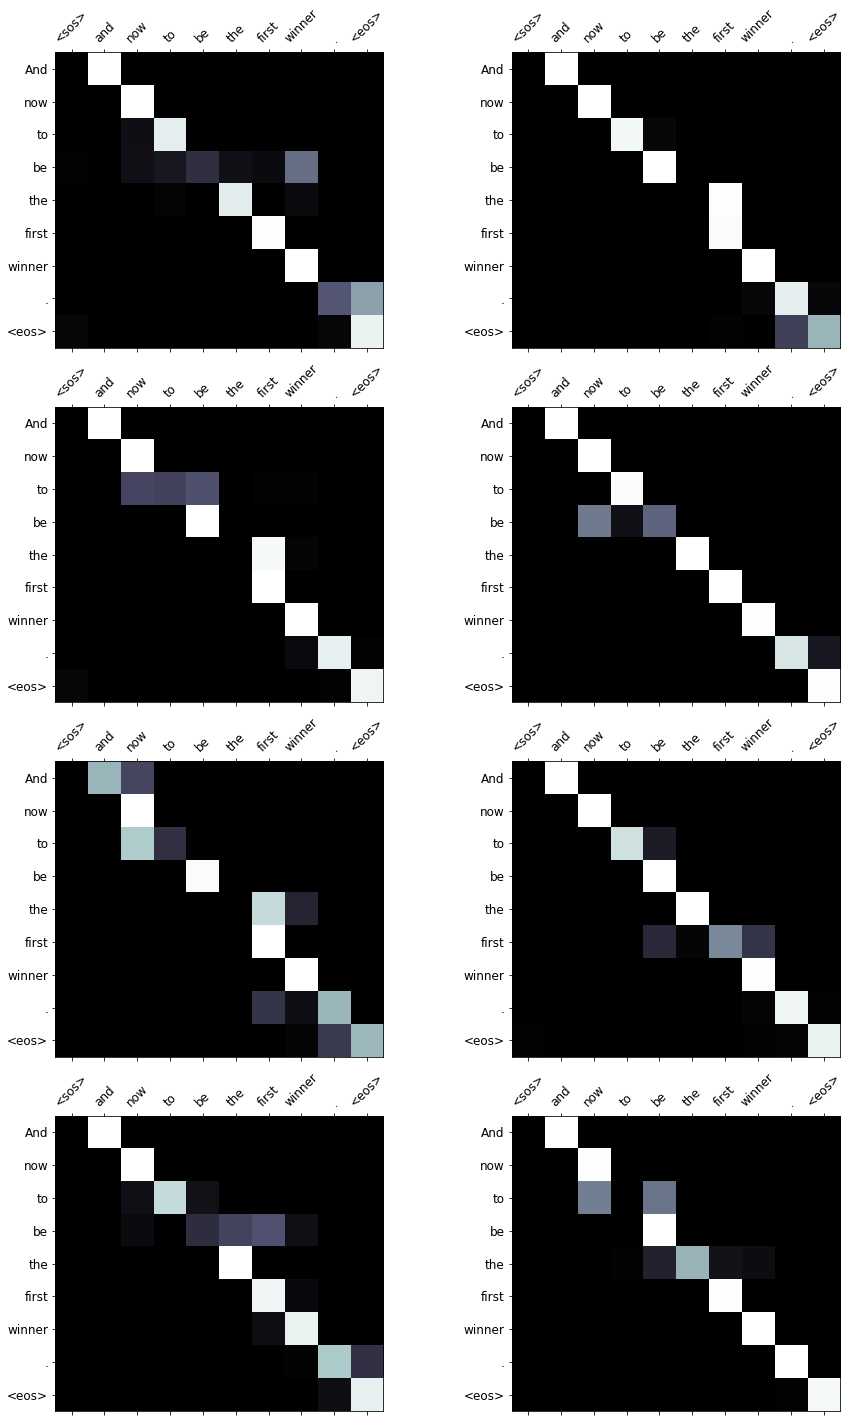

In [23]:
print("validating inference")
inference(valid_set, src_field, trg_field, model)

testing inference
src = The Albert Hall College , the building where will be taken part the conference is sited near Green Park Avenue ; so , to get it from the Palace Hotel you can take the bus number 26 , otherwise , you can take the Picadilly Line from South Kensigton Station to green Park station .
trg = The Albert Hall College , the building where the conference will be held is situated near Green Park Avenue . To get to it from the Palace Hotel , you can take the number 26 bus , otherwise , you can take the Picadilly Line from South Kensigton station to Green Park station .
out = The Albert Hall , the building where the part will be conferennconfersmetics is near future vik ; so , to get a Paulty , the beginning you can take the 2aise from the BApulty , otherwise you can take a Piaise , otherwise Kennings you go to the Bencadicacadicacadicau Kenk is near Benk is near Benk
---


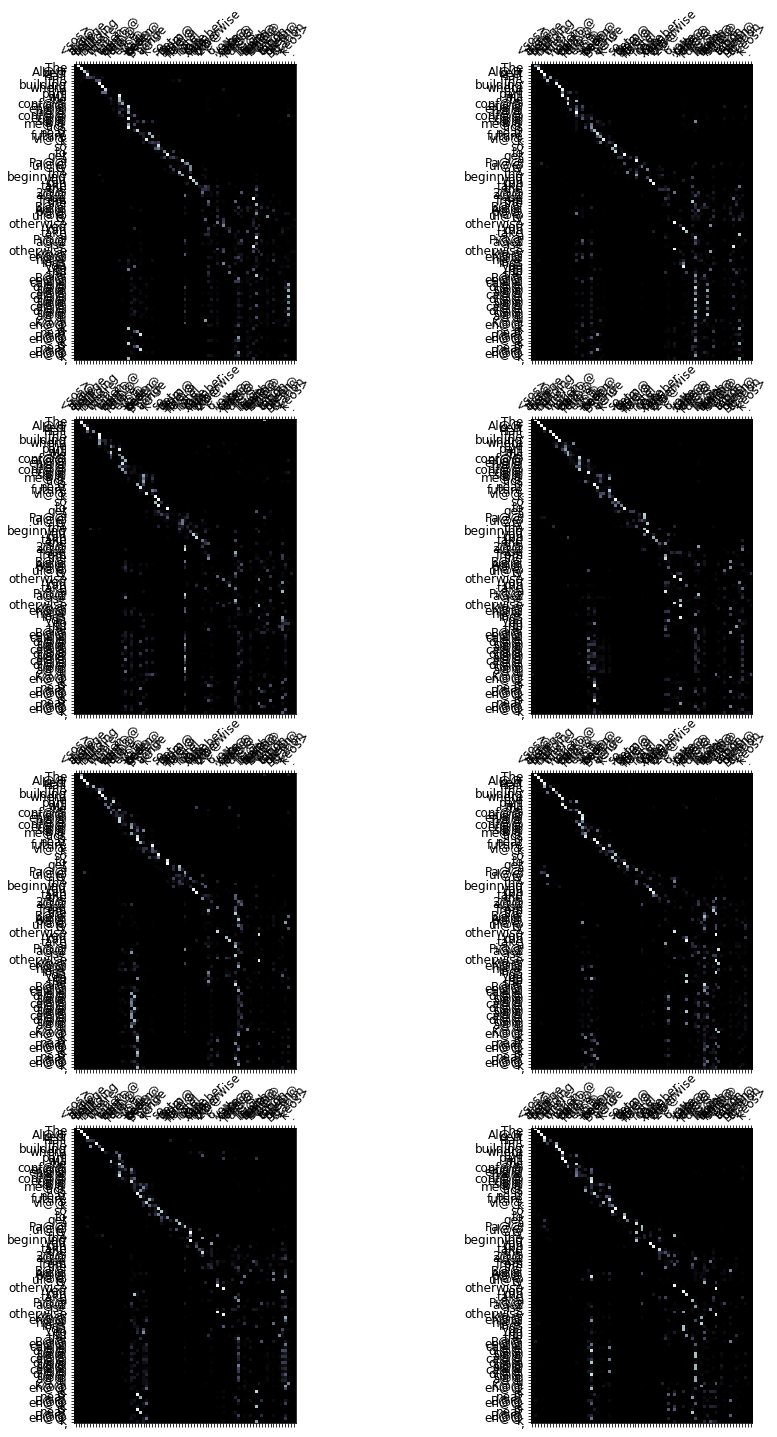

src = The TV is so important that you can see it in every family , and it is a essential equipment for everyone .
trg = The TV is so important that you can see one in every home , and it is an essential item for everyone .
out = The TV is so important that you can see it in every family , and it is a essential equipment for everyone .
---


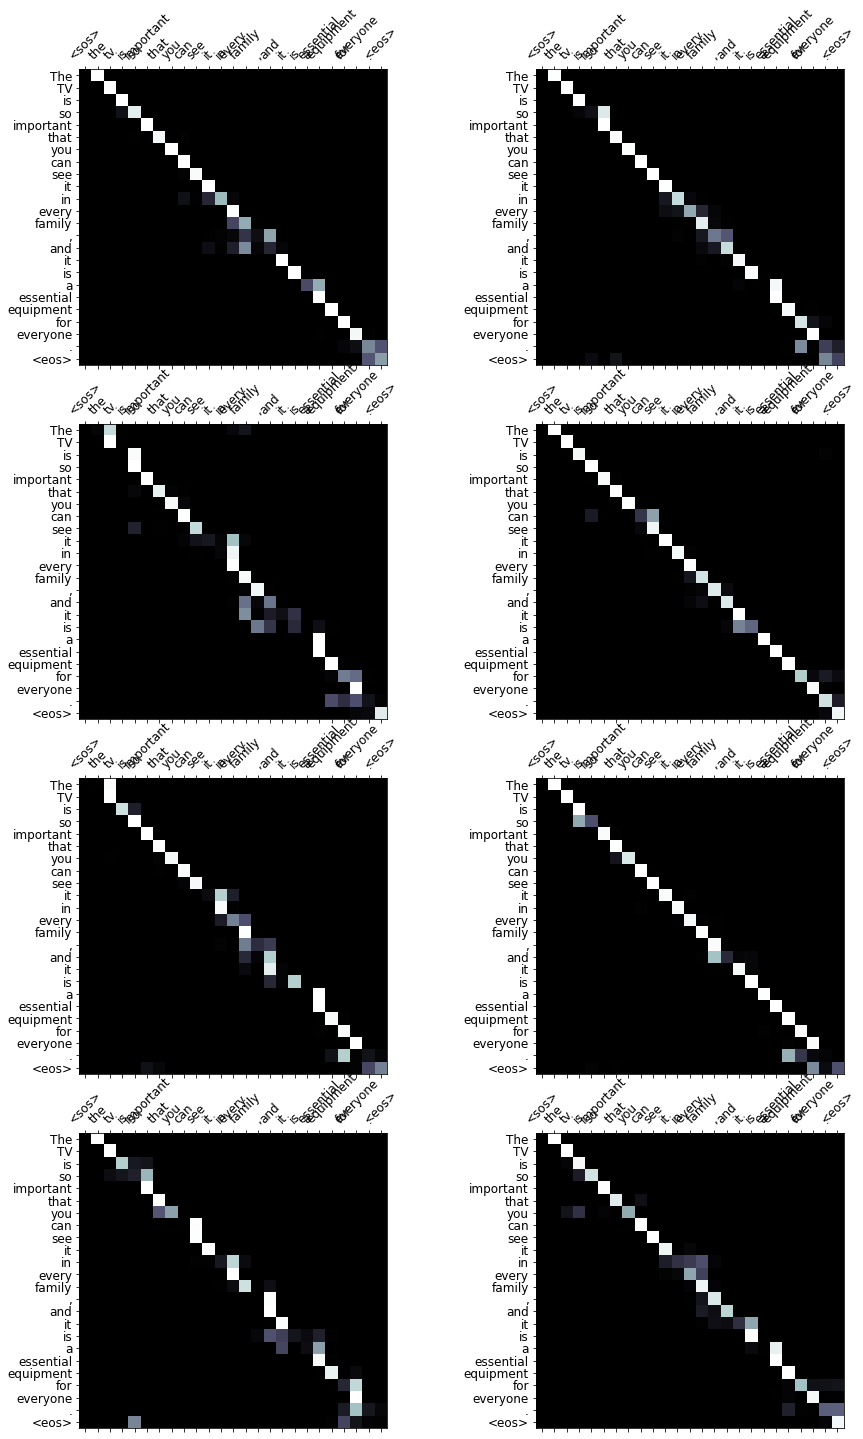

src = Please oblige us with your attendance .
trg = Please oblige us with your attendance .
out = Please lily us with your attendance .
---


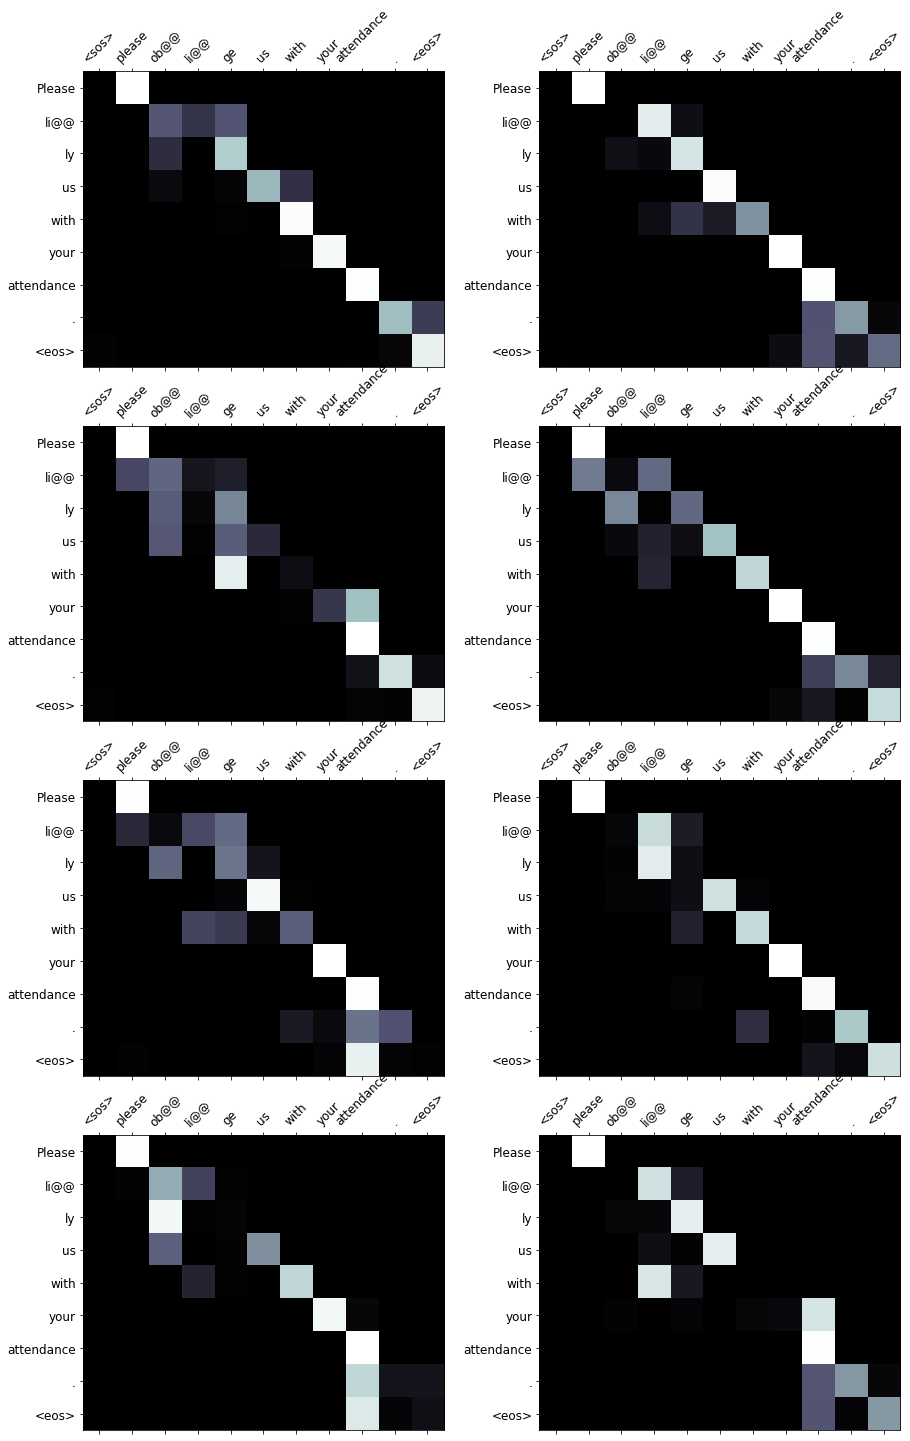

src = It is somenthing very particular , its paviment made from many small pecis of wood , its windows with many colours , it is fantastic .
trg = It is something very special . Its ceiling is made from many small pieces of wood . Its windows with many colours . It is fantastic .
out = It is something very particular , its point of its pations made from many small pecpecpecpecwood , with many colours , it is fantastic .
---


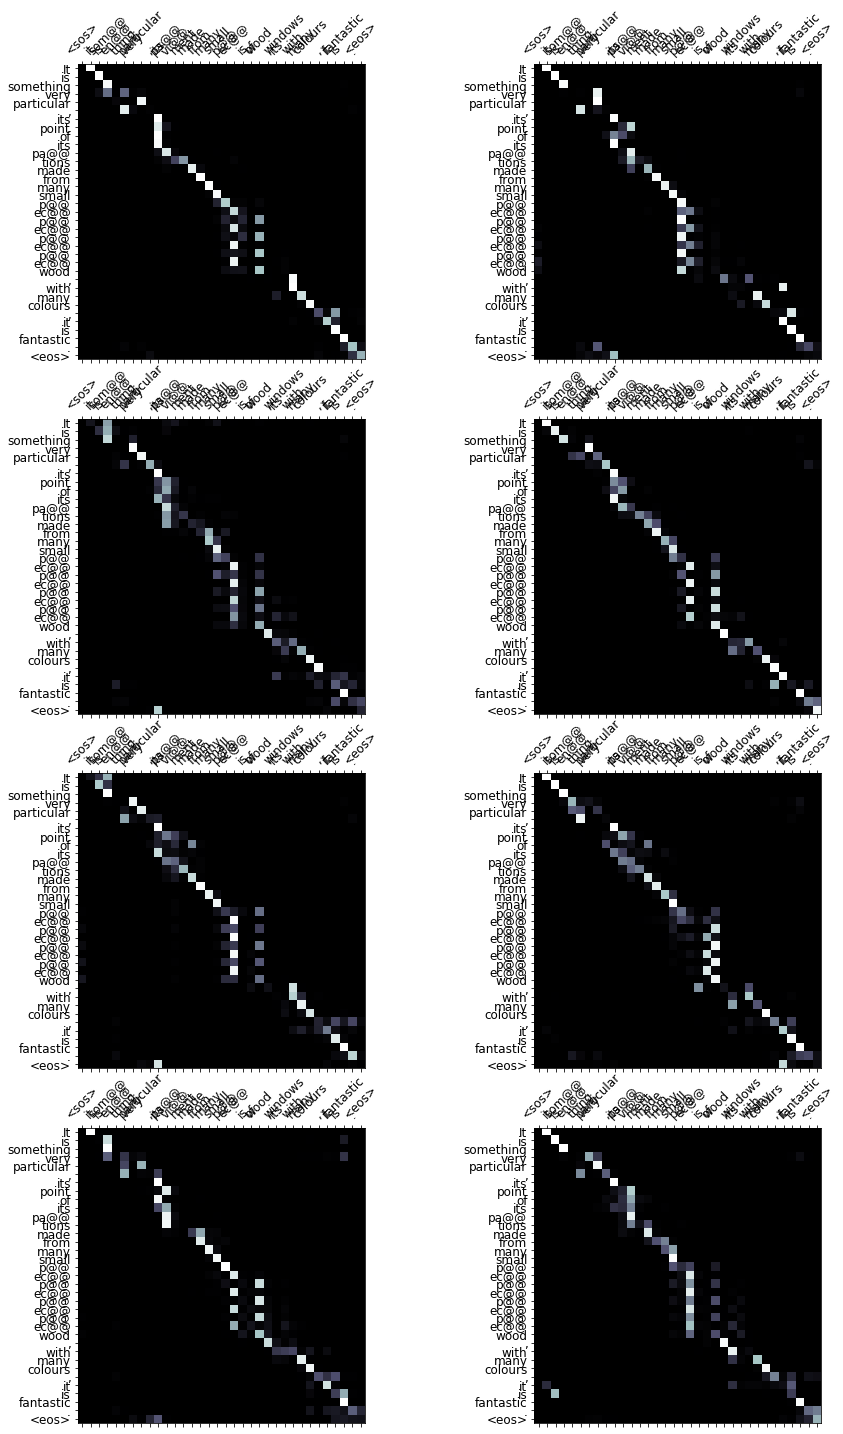

src = The conference is situatet in the building opposite the bus stop .
trg = The conference is taking place in the building opposite the bus stop .
out = The confereniatet in the opposite the opposite stopped .
---


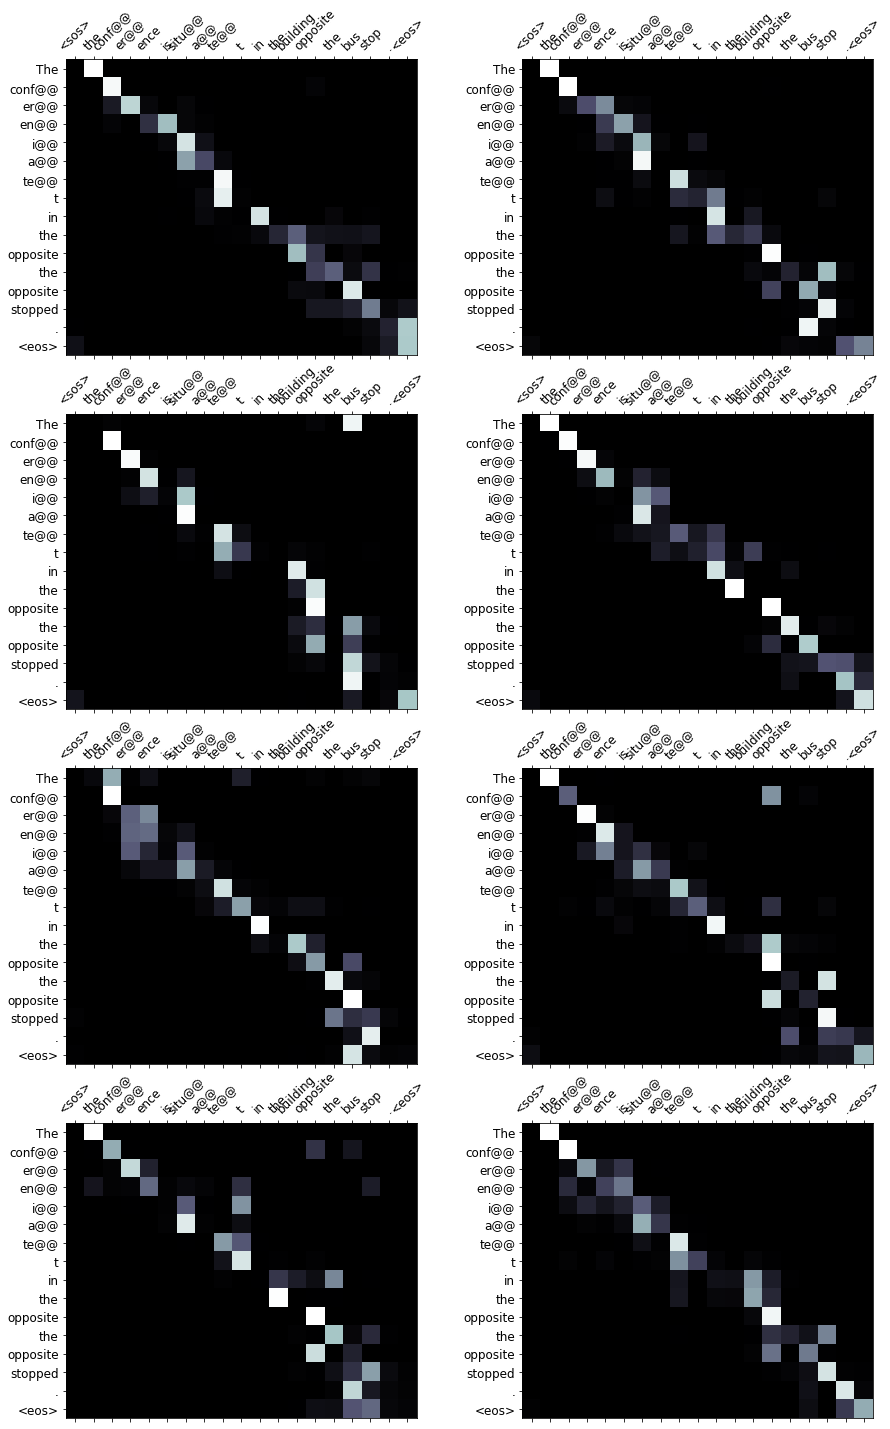

src = All different types of clothing could be worn however jean wears and T - shirts would be common on that day .
trg = Different types of clothing can be worn . However , jean wears and T - shirts will be common on that day .
out = All different types of clothing could be wore including watched and T - shirts will be common on that day .
---


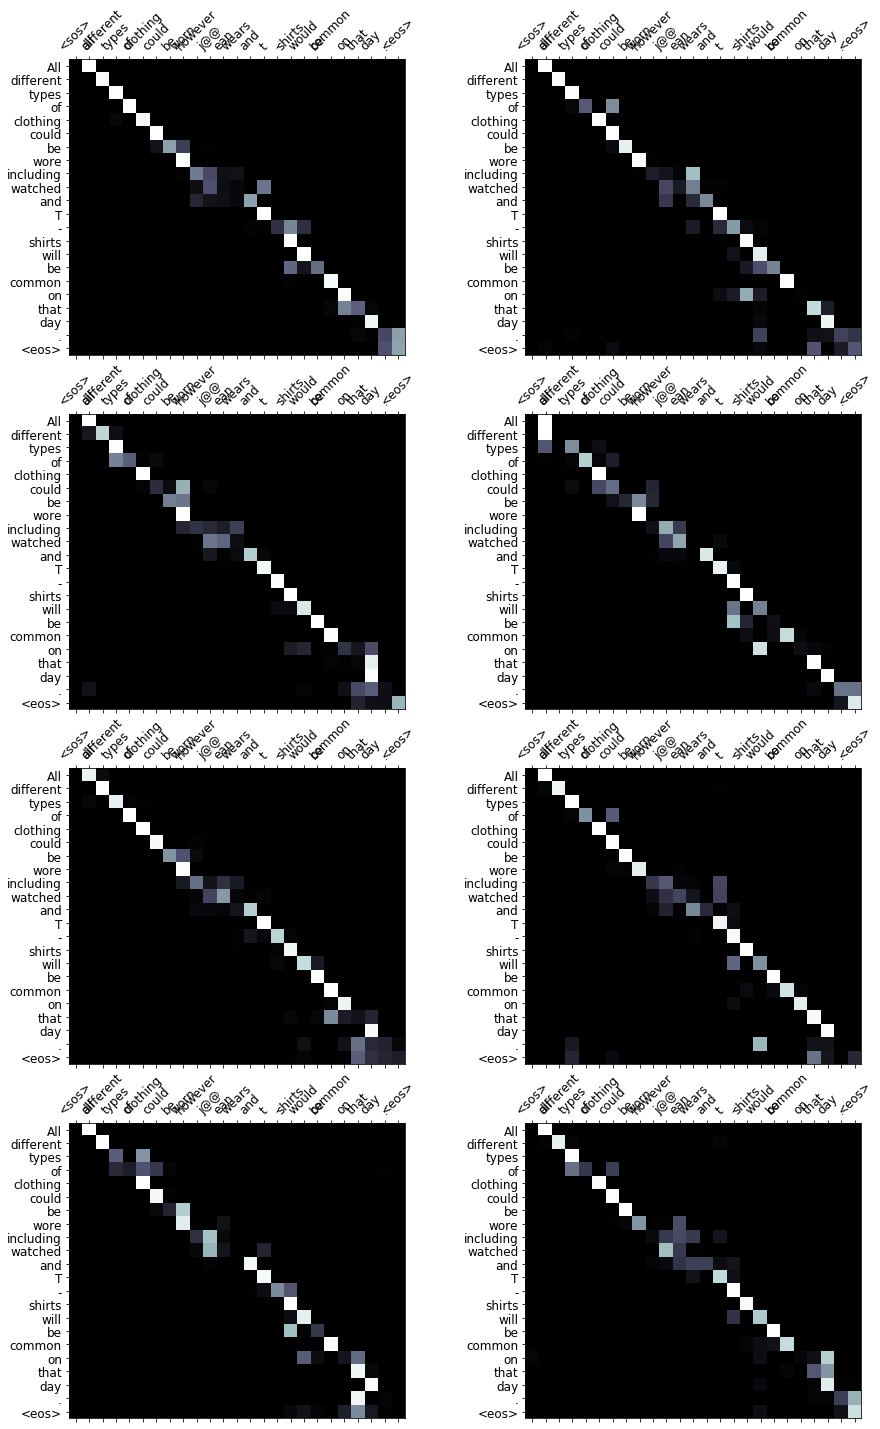

src = It has been a plus for me .
trg = It has been a plus for me .
out = It has been plus for me .
---


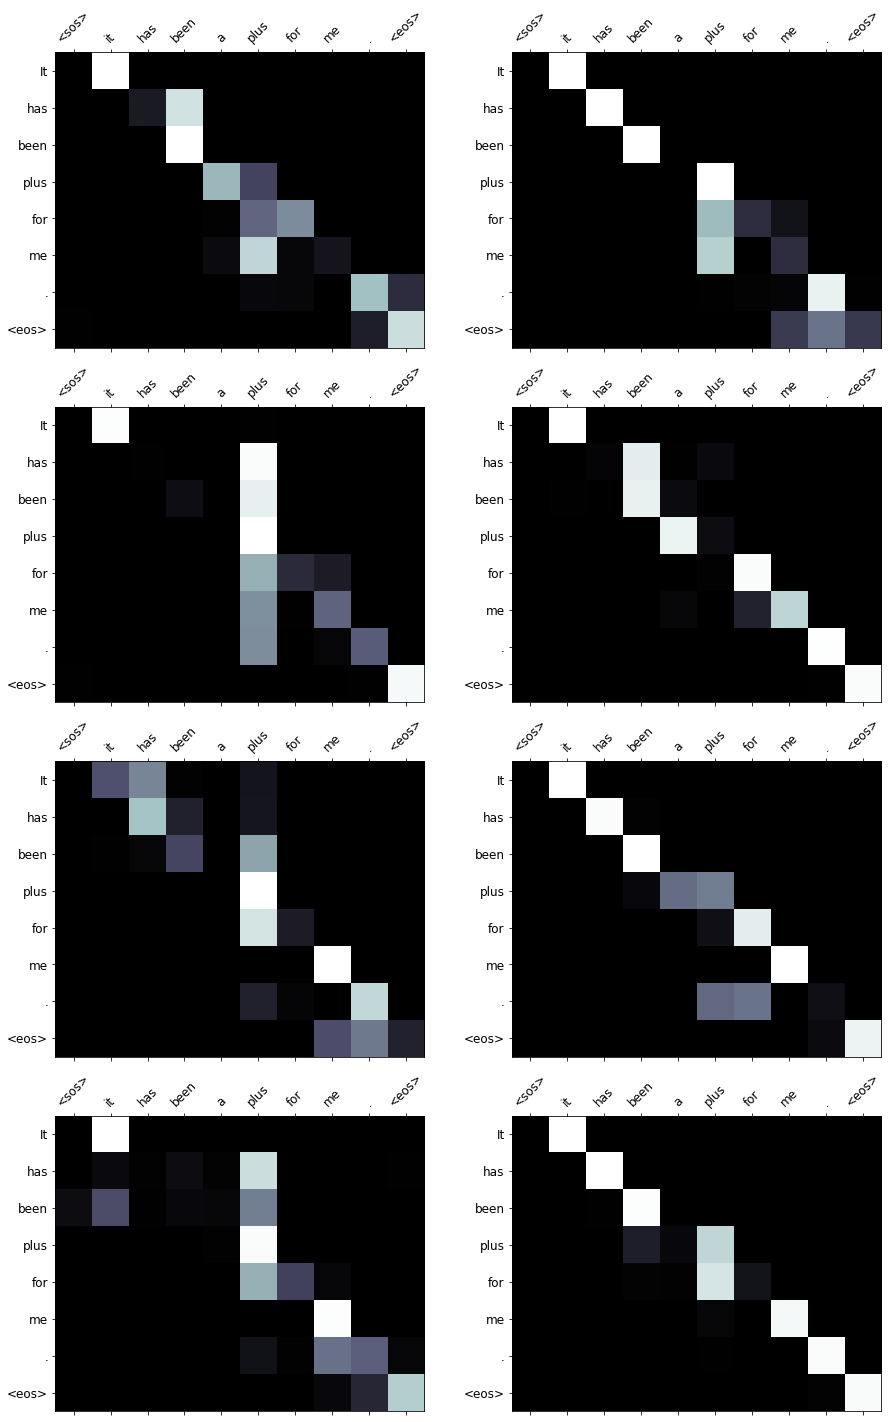

src = 1 ) First of all , there are sited in the center of Rome so , they can take a bus to get them move and around the city .
trg = 1 ) First of all , they are located in the centre of Rome so they can take a bus to get to them move and around the city .
out = 1 ) first of all , there are decided in the centre of Rome , so they can take a bus to get to get them and move around the city .
---


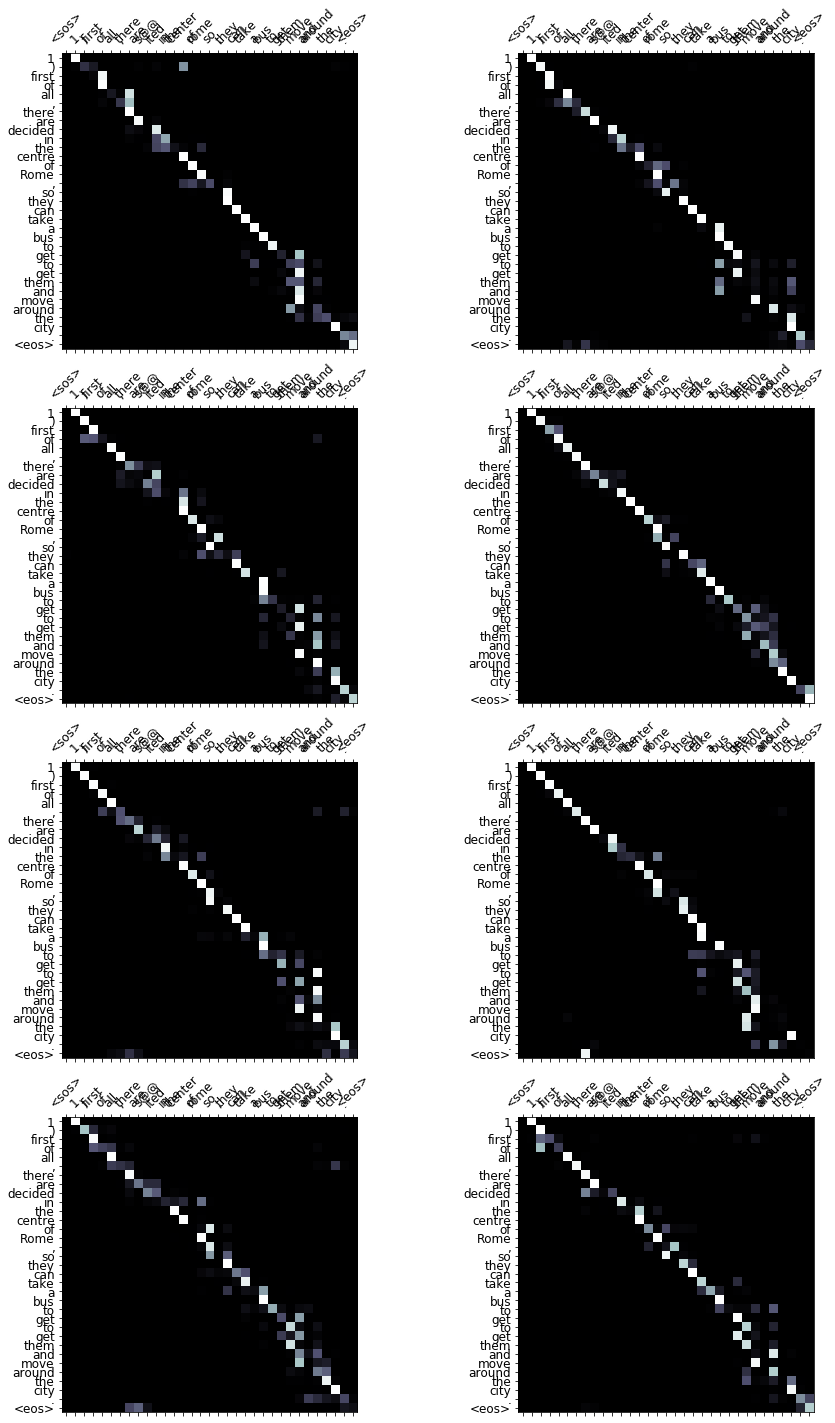

src = About the clothes that we need to wear , must be uniform , because is the best conference to London and every year are coming lectures from other colleges .
trg = About the clothes that you need to wear , it must be your uniform , because it is the best conference in London and every year lecturers come from other colleges .
out = About the clothes that we need to wear , must be uniform , because it is the best conferenence and every year are coming from the audience , from other people who come from the other leers .
---


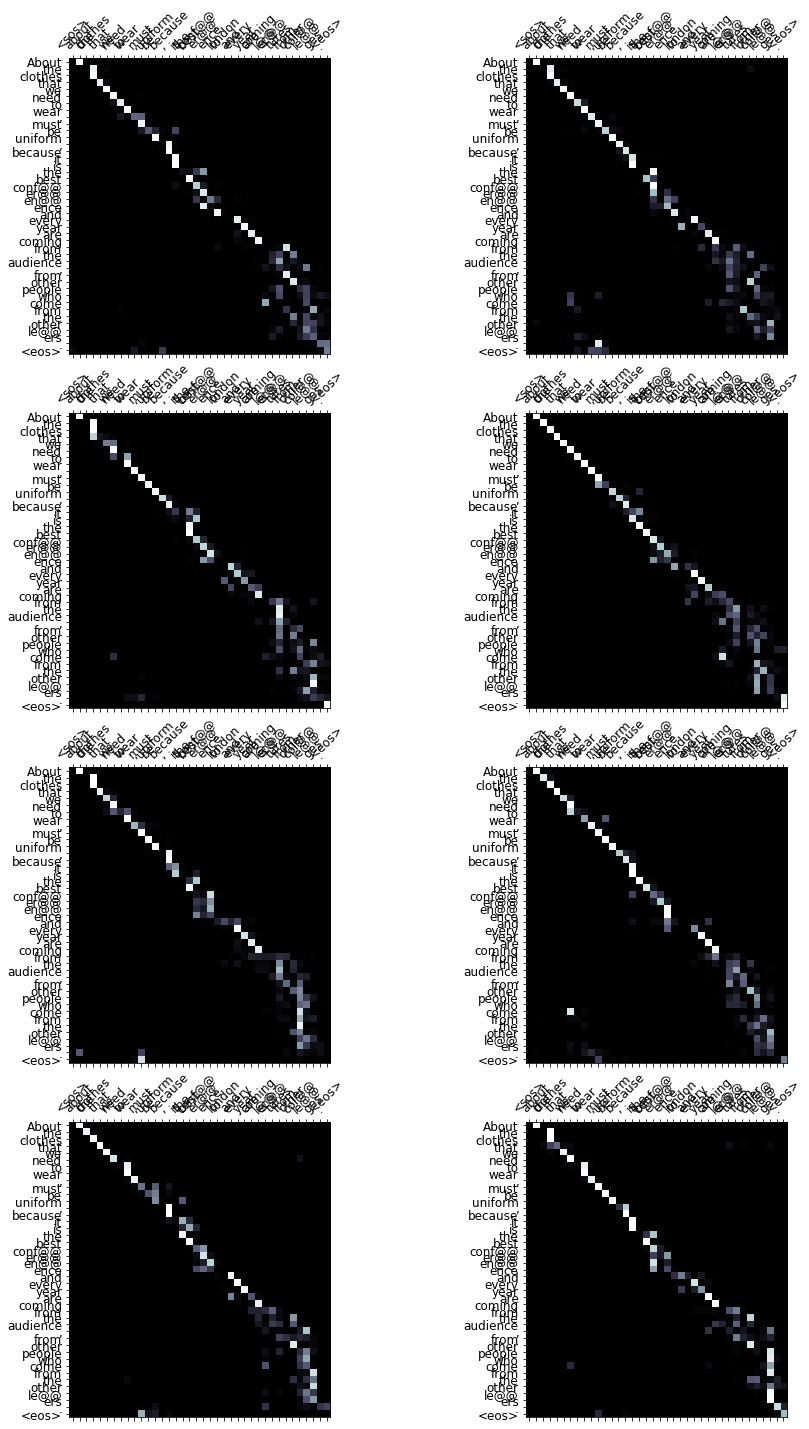

src = Firstly , the Palace hotel is your accommodation which you have booked .
trg = Firstly , the Palace hotel is your accommodation which you have booked .
out = Firstly , the Pams is your hotel , which you have booked .
---


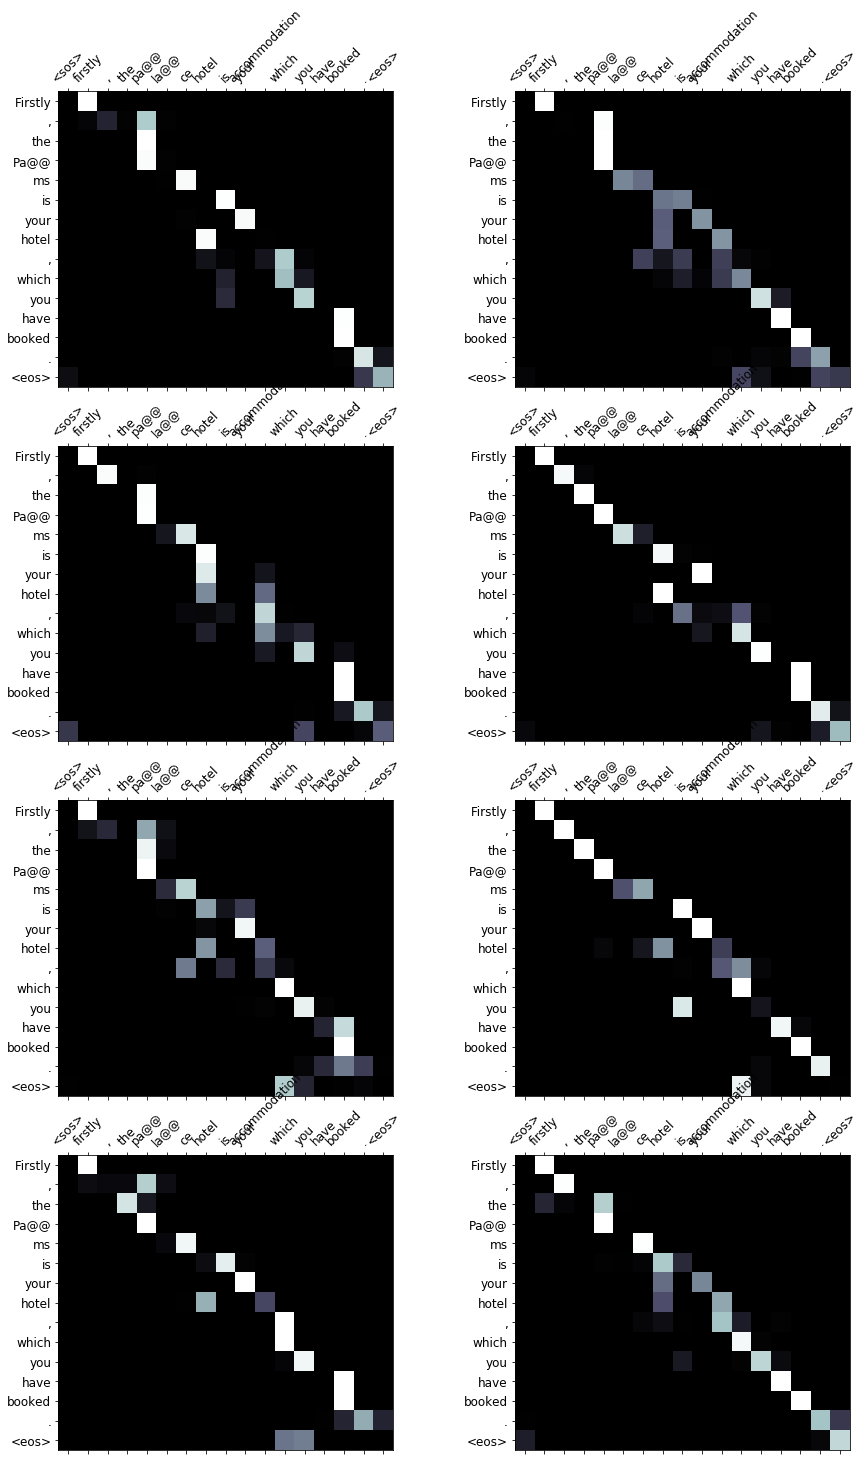

In [24]:
print("testing inference")
inference(test_set, src_field, trg_field, model)

In [25]:
bleu = calculate_bleu(test_set, src_field, trg_field, model)
print(f"BLEU score = {bleu * 100:.2f}")

BLEU score = 58.80
